In [ ]:
import pandas as pd
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import random
random.seed(42)

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve
from joblib import Parallel, delayed
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
label_path = "/content/drive/MyDrive/muri/label_numpy/label"

In [ ]:
spectrogram_path = "/content/drive/MyDrive/muri/spectrogram_numpy/spectrogram"

In [ ]:
ch1_labels = []
ch2_labels = []
chirp_labels_list = []

In [ ]:
ch1_labels.append(np.load(f'{label_path}/3.565-Chirp_3_label.npy'))
ch1_labels.append(np.load(f'{label_path}/3.565-Chirp_4_label.npy'))

ch2_labels.append(np.load(f'{label_path}/3.555-Chirp_2_label.npy'))
ch2_labels.append(np.load(f'{label_path}/3.555-Chirp_3_label.npy'))

In [ ]:
chirp_labels_list.append(np.load(f'{label_path}/Chirp_1_label.npy'))
chirp_labels_list.append(np.load(f'{label_path}/Chirp_2_label.npy'))

In [ ]:
chirp_labels = np.hstack(chirp_labels_list)

In [ ]:
channel_1_labels = np.hstack(ch1_labels)
channel_2_labels = np.hstack(ch2_labels)

In [ ]:
y = np.hstack([chirp_labels, channel_1_labels, channel_2_labels])

In [ ]:
index_dict = {}
for i in range(1,13):
    index_dict[i] = np.where(y == i)[0]

In [ ]:
ch_1_spec = []
ch_2_spec = []
chirp_spec = []

ch_1_spec.append(np.load(f'{spectrogram_path}/3.565-Chirp_3.npy'))
ch_1_spec.append(np.load(f'{spectrogram_path}/3.565-Chirp_4.npy'))
ch_2_spec.append(np.load(f'{spectrogram_path}/3.555-Chirp_2.npy'))
ch_2_spec.append(np.load(f'{spectrogram_path}/3.555-Chirp_3.npy'))
chirp_spec.append(np.load(f'{spectrogram_path}/Chirp_1.npy'))
chirp_spec.append(np.load(f'{spectrogram_path}/Chirp_2.npy'))

In [ ]:
ch_1_spec_data = np.vstack(ch_1_spec)
ch_2_spec_data = np.vstack(ch_2_spec)
chirp_spec_data = np.vstack(chirp_spec)


In [ ]:
X_spec = np.vstack([chirp_spec_data, ch_1_spec_data, ch_2_spec_data])

In [ ]:
def get_sample_spectrograms_same_label(label):
    sample_spec_points = []
    sample_spec_points_idx = index_dict[label]  
    # fig, ax = plt.subplots(4, 3, figsize=(15,15))
    # fig.suptitle(f'Label: {label}', fontsize=20)
    for i in sample_spec_points_idx:
        sample_spec_points.append(X_spec[i])
    
    # for idx, sample_signal_spec in enumerate(sample_spec_points):
    #     row, col = idx//3,idx%3
    #     sns.heatmap(sample_signal_spec, ax=ax[row][col])
    # fig.tight_layout()
    # plt.show()

    return sample_spec_points

In [ ]:
np.array(get_sample_spectrograms_same_label(1)).shape

(18727, 64, 64)

0: Empty 

1: Radar 

2: LTE 

3: Collision

In [ ]:
label_to_splitChannel = {1:(0,0),
                         2:(1,0),
                         3:(0,1),
                         4:(1,1),
                         5:(2,0),
                         6:(0,2),
                         7:(2,1),
                         8:(1,2),
                         9:(3,0),
                         10:(0,3),
                         11:(3,1),
                         12:(1,3)}


In [ ]:
splitChannel_to_label = {v: k for k, v in label_to_splitChannel.items()}

In [ ]:
from collections import defaultdict

In [ ]:
count_channel_1=defaultdict(int)
count_channel_2=defaultdict(int)

In [ ]:
for label in list(y):
  ch1,ch2 = label_to_splitChannel[label]
  count_channel_1[ch1]+=1
  count_channel_2[ch2]+=1 

In [ ]:
count_channel_1=dict(count_channel_1)

In [ ]:
count_channel_2=dict(count_channel_2)

In [ ]:
count_channel_1_values,count_channel_2_values=[],[]
for i in range(4):
  count_channel_1_values.append(count_channel_1[i])
  count_channel_2_values.append(count_channel_2[i])  #this is similar to just doing dict.values() but this makes sure '0' is first and '1' is second

In [ ]:
len_all_records  = sum(count_channel_1_values) #=sum(count_channel_2_values)

In [ ]:
# prob_dist_channel_1 = [count/len_all_records for count in count_channel_1_values]
prob_dist_channel_1=[0.25]*len(count_channel_1_values)

In [ ]:
print(count_channel_1_values,count_channel_2_values)

[31222, 4475, 12156, 1341] [32733, 3232, 12069, 1160]


In [ ]:
prob_dist_channel_1

[0.25, 0.25, 0.25, 0.25]

In [ ]:
# prob_dist_channel_2 = [count/len_all_records for count in count_channel_2_values]
prob_dist_channel_2 = [0.25]*len(count_channel_2_values)

In [ ]:
prob_dist_channel_2

[0.25, 0.25, 0.25, 0.25]

In [ ]:
choices_channel_1=np.random.choice(4, len_all_records, p=prob_dist_channel_1)
choices_channel_2=np.random.choice(4, len_all_records, p=prob_dist_channel_2)

In [ ]:
choices_splitChannel = list(zip(choices_channel_1,choices_channel_2))

In [ ]:
choices_labels=[]
for choice in choices_splitChannel:
  if choice in splitChannel_to_label:
    choices_labels.append(splitChannel_to_label[choice])

In [ ]:
unique, counts = np.unique(choices_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   1 3149]
 [   2 3152]
 [   3 3024]
 [   4 3080]
 [   5 3152]
 [   6 3051]
 [   7 2940]
 [   8 3068]
 [   9 3089]
 [  10 3140]
 [  11 3114]
 [  12 3067]]


In [ ]:
spec_pool_by_label = {}
for label in range(1,13):
  spec_pool_by_label[label]= get_sample_spectrograms_same_label(label)

In [ ]:
dataset=[]
for label in choices_labels:
  dataset.append(random.sample(spec_pool_by_label[label],50))
  # dataset = np.append(dataset,random.sample(spec_pool_by_label[label],50),axis=0)

In [ ]:
import pickle
with open('dataset_list.pkl','wb') as f:
  pickle.dump(dataset,f)

with open('label_list.pkl','wb') as f:
  pickle.dump(choices_labels,f)

In [ ]:
import pickle
with open('spec_pool.pkl','wb') as f:
  pickle.dump(spec_pool_by_label,f)

Visualizing H-score model results 

In [ ]:
import torch

In [ ]:
import os
import pickle
import time
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm

import random
random.seed(42)

In [ ]:
# class CNNModel(nn.Module): #OLD
#     def __init__(self):
#         super(CNNModel, self).__init__()

#         # Convolution 1
#         self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8, stride=1)
#         self.relu1 = nn.ReLU()

#         # Max pool 1
#         self.maxpool1 = nn.MaxPool2d(kernel_size=4)

#         # Fully connected 1 (readout)
#         # self.fc1 = nn.Linear(5184, 15)
#         self.fc1 = nn.Linear(196, 16)
#         self.sigmoid1 = nn.Sigmoid()

#     def forward(self, x):
#         x = x.squeeze(1)
#         out = self.cnn1(x)
#         out = self.relu1(out)
#         out = self.maxpool1(out)
#         im_out = out
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.sigmoid1(out)
#         return im_out, out

In [ ]:
# class CNNModel(nn.Module):
#     def __init__(self):
#         super(CNNModel, self).__init__()

#         # Convolution 1
#         self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8, stride=1)
#         self.relu1 = nn.ReLU()

#         # Max pool 1
#         self.maxpool1 = nn.MaxPool2d(kernel_size=5)

#         # Fully connected 1 (readout)
#         # self.fc1 = nn.Linear(5184, 15)
#         self.fc1 = nn.Linear(1936, 100)
#         self.sigmoid1 = nn.Sigmoid()

#     def forward(self, x):
#         out = self.cnn1(x)
#         out = self.relu1(out)
#         out = self.maxpool1(out)
#         im_out = out
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.sigmoid1(out)
#         return im_out, out

In [ ]:
# learned_feature_size = 10

In [ ]:
# class CNNModel(nn.Module):
#     def __init__(self):
#         super(CNNModel, self).__init__()

#         # Convolution 1
#         self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8, stride=1)
#         self.relu1 = nn.ReLU()

#         # Max pool 1
#         self.maxpool1 = nn.MaxPool2d(kernel_size=5)

#         # Fully connected 1 (readout)
#         # self.fc1 = nn.Linear(5184, 15)
#         self.fc1 = nn.Linear(1936, 640)
#         self.fc2 = nn.Linear(640,learned_feature_size**2)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         out = self.cnn1(x)
#         out = self.relu1(out)
#         out = self.maxpool1(out)
#         im_out = out
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.sigmoid(out)
#         out = self.fc2(out)
#         out = self.sigmoid(out)
#         return im_out, out

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8, stride=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)

        # Fully connected 1 (readout)
        # self.fc1 = nn.Linear(5184, 15)
        self.fc1 = nn.Linear(1936, 640)
        self.fc2 = nn.Linear(640,12)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        im_out = out
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return im_out, out

In [ ]:
model =CNNModel()
model.load_state_dict( torch.load('/content/drive/MyDrive/muri/new_cnn_model_50.pth',map_location='cpu'))
model.eval()

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(8, 8), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1936, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=12, bias=True)
  (sigmoid): Sigmoid()
)

Visualize Learned features


In [ ]:
def plot_heatmap(nd_array):
  plt.imshow(nd_array, cmap='hot', interpolation='nearest')
  plt.show()

In [ ]:
def plot_image(nd_array):
  plt.imshow(nd_array)
  plt.show()


Label 1


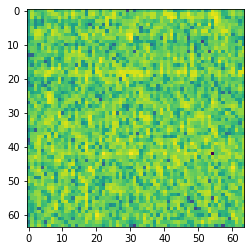

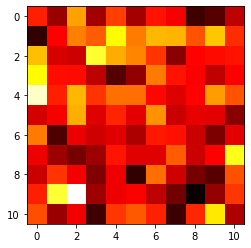

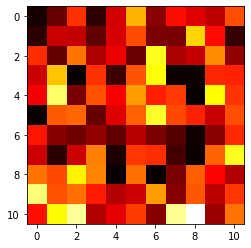

Label 2


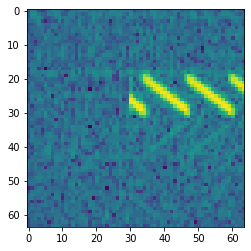

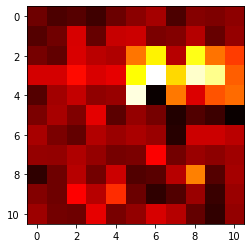

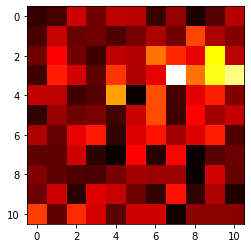

Label 3


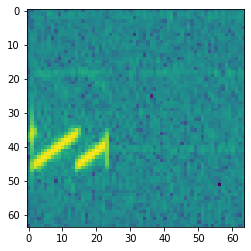

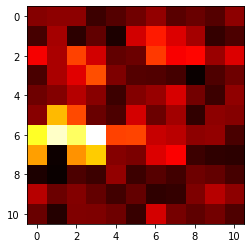

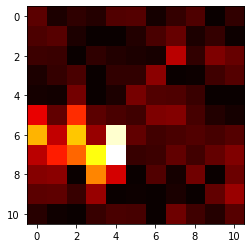

Label 4


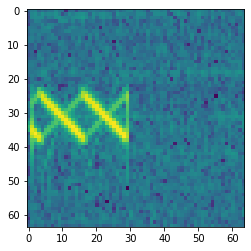

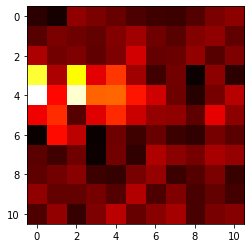

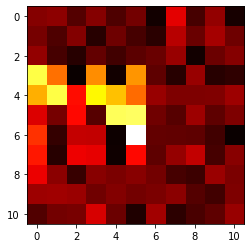

Label 5


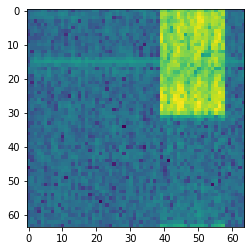

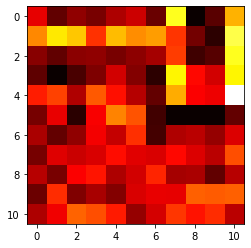

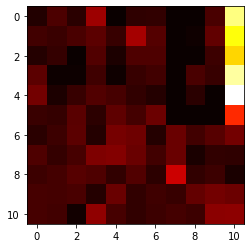

Label 6


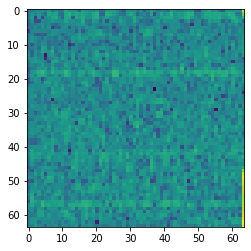

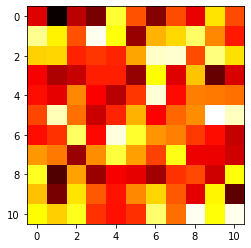

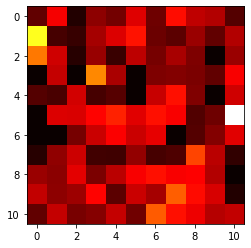

Label 7


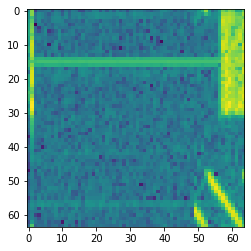

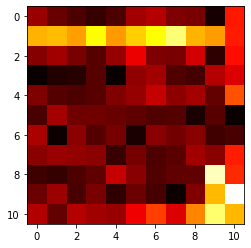

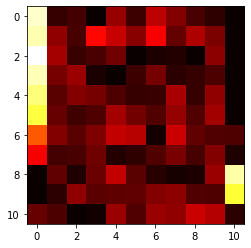

Label 8


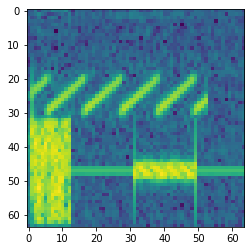

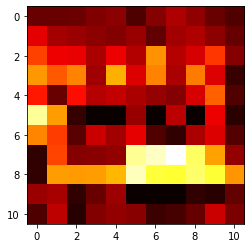

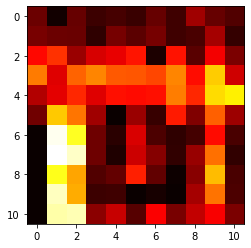

Label 9


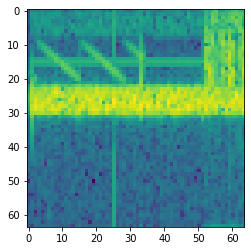

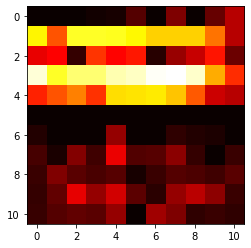

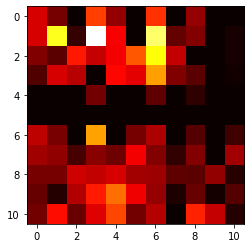

Label 10


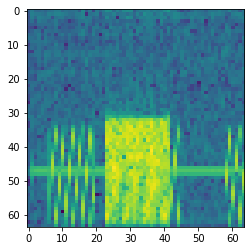

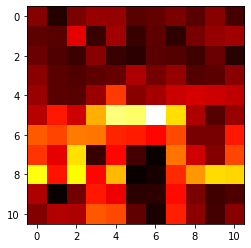

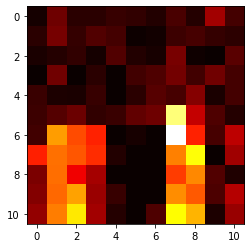

Label 11


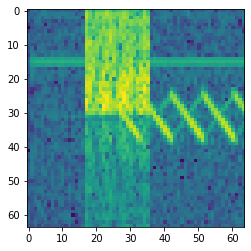

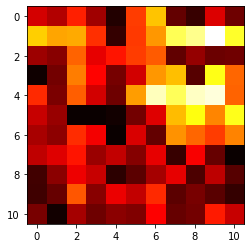

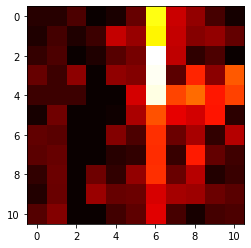

Label 12


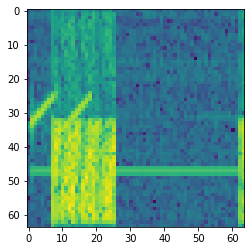

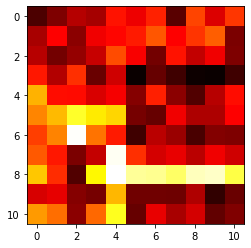

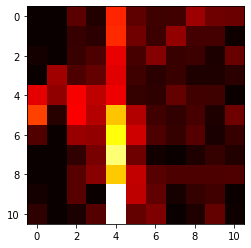

In [ ]:
for i in range(1,13): #old_20_eps model
  print("Label",i)
  # img1 = model(torch.from_numpy(spec_pool_by_label[i][0]).unsqueeze(0).unsqueeze(0).float())[1].reshape(10,10)
  # img2= model(torch.from_numpy(spec_pool_by_label[i][25]).unsqueeze(0).unsqueeze(0).float())[1].reshape(10,10)
  heatMaps= model(torch.from_numpy(spec_pool_by_label[i][0]).unsqueeze(0).unsqueeze(0).float())[0].squeeze(0)
  plot_image(spec_pool_by_label[i][0])
  plot_heatmap(heatMaps[0].detach().numpy())
  plot_heatmap(heatMaps[1].detach().numpy())


Label 1


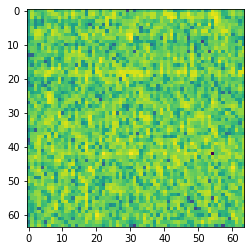

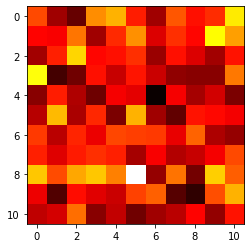

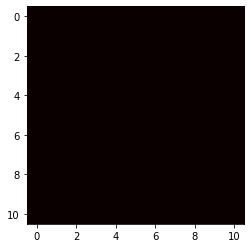

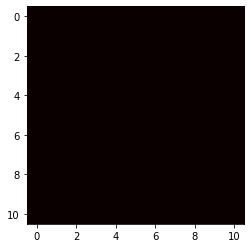

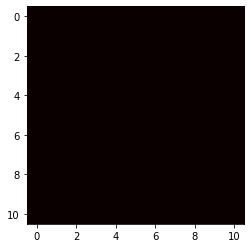

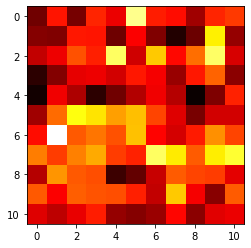

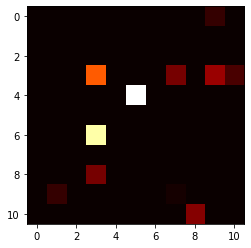

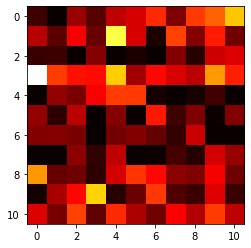

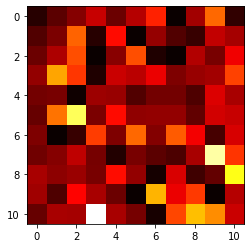

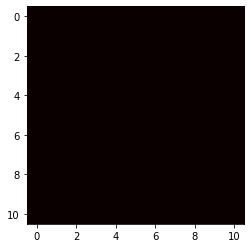

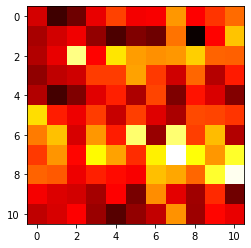

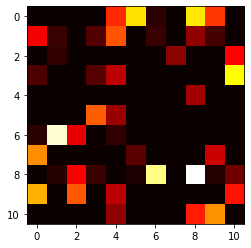

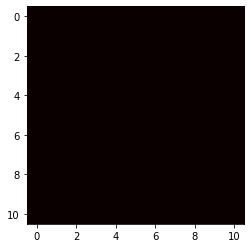

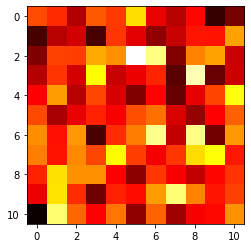

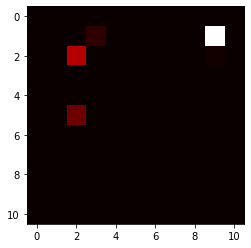

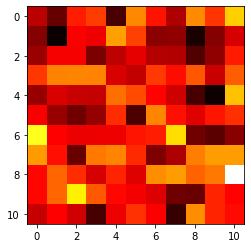

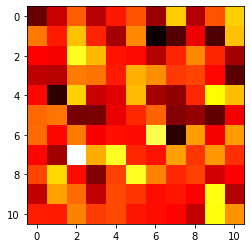

Label 2


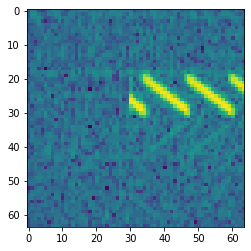

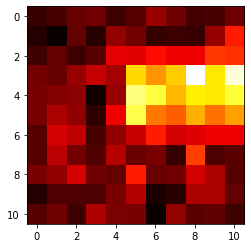

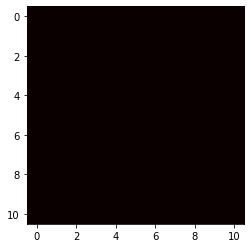

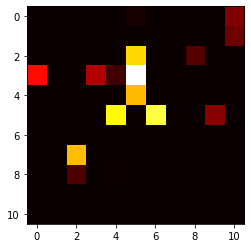

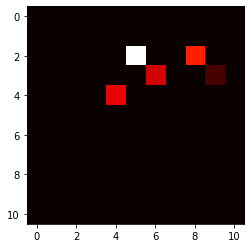

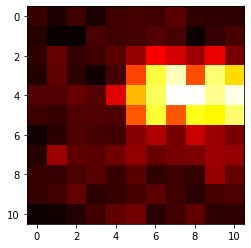

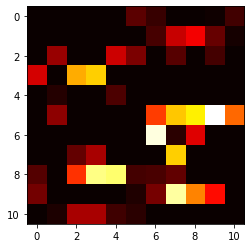

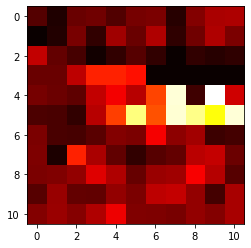

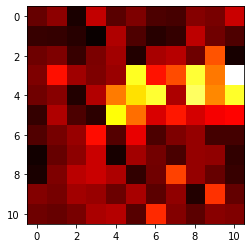

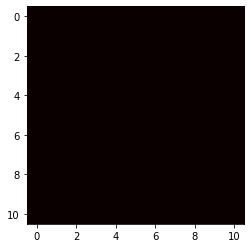

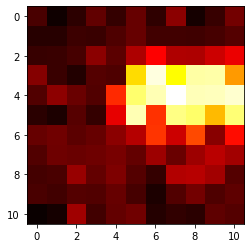

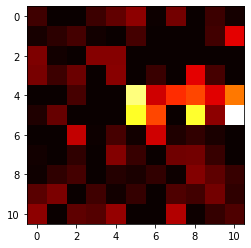

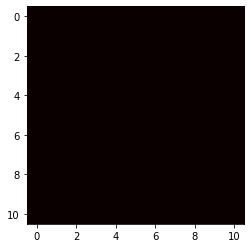

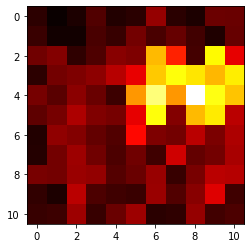

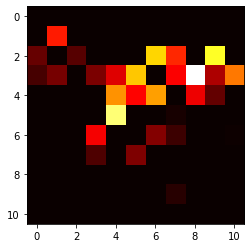

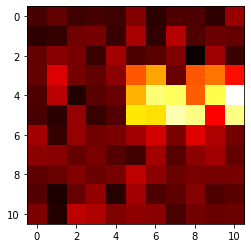

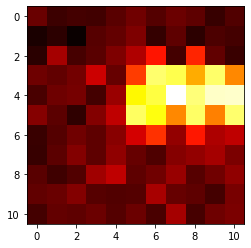

Label 3


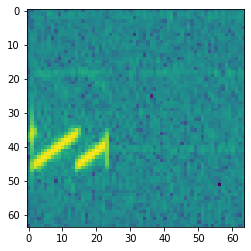

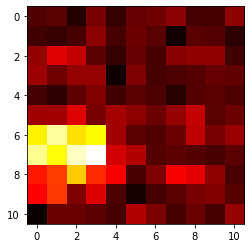

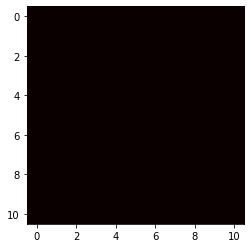

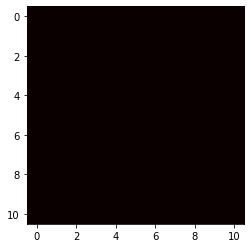

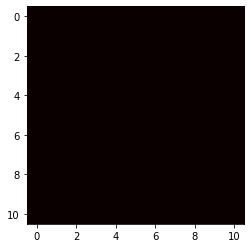

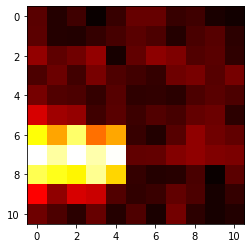

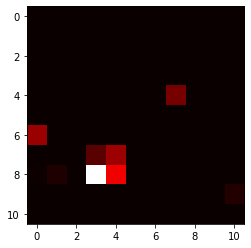

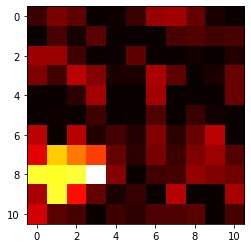

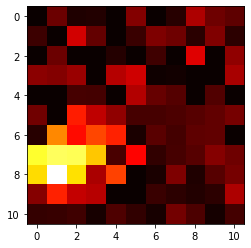

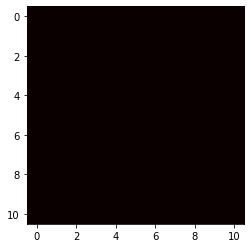

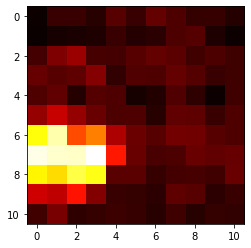

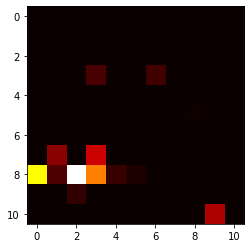

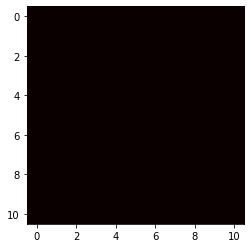

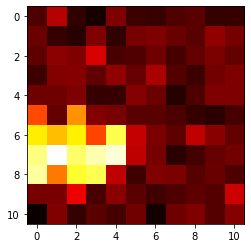

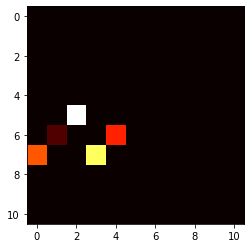

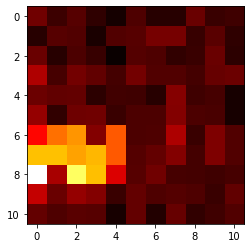

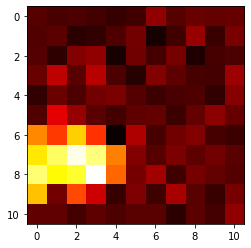

Label 4


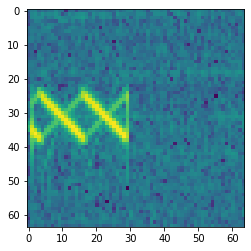

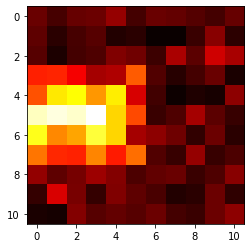

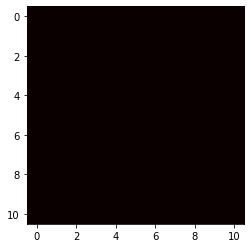

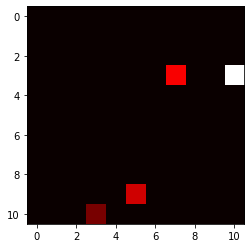

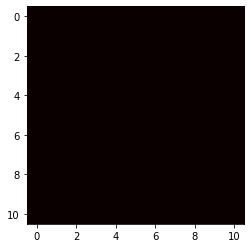

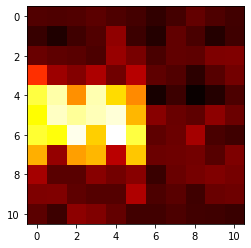

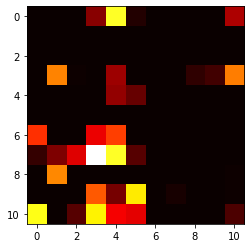

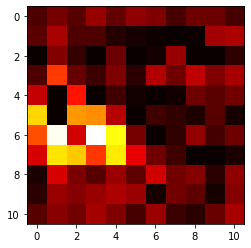

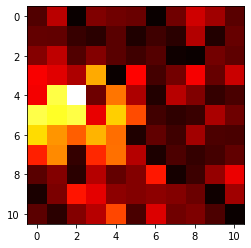

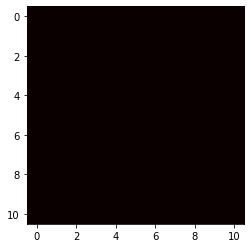

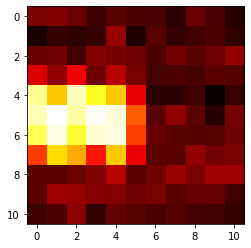

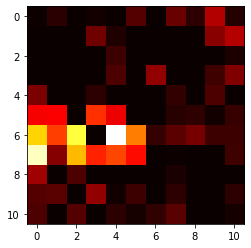

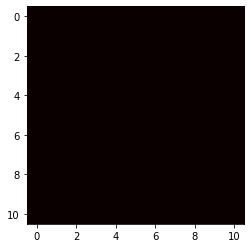

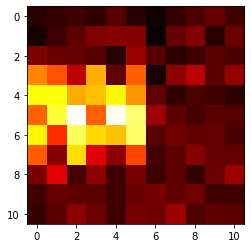

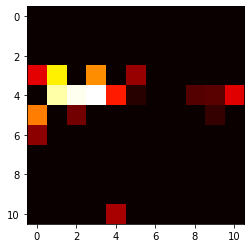

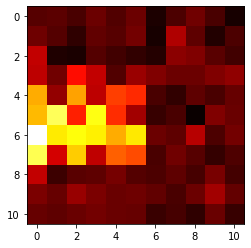

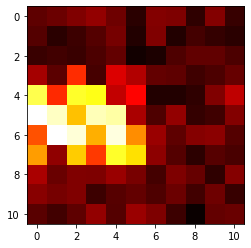

Label 5


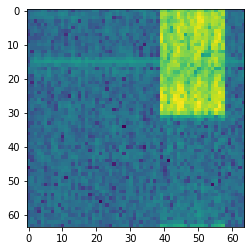

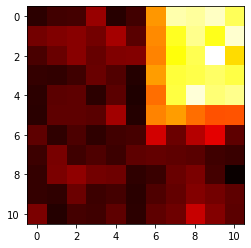

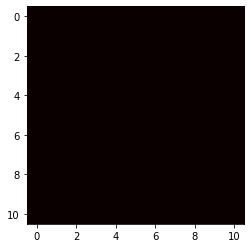

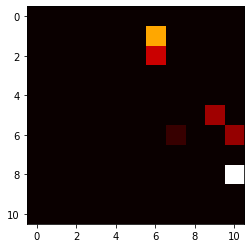

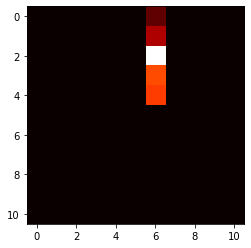

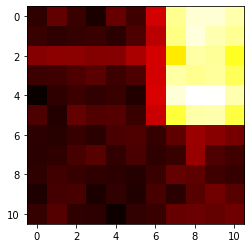

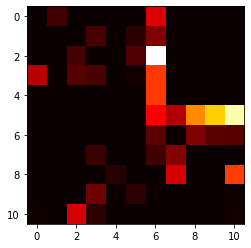

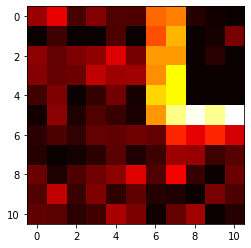

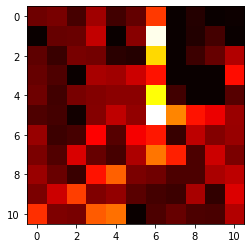

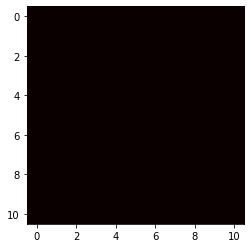

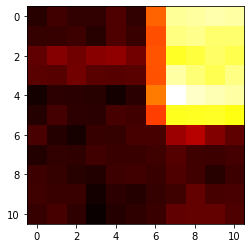

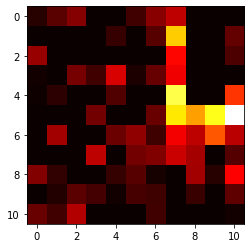

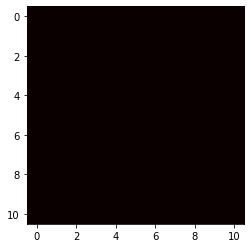

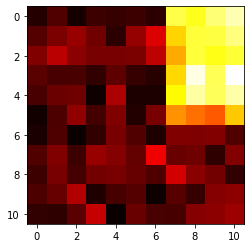

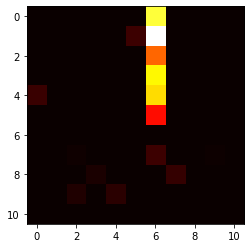

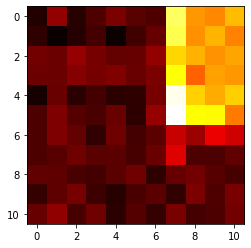

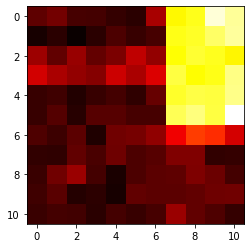

Label 6


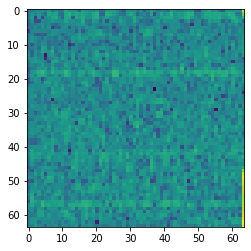

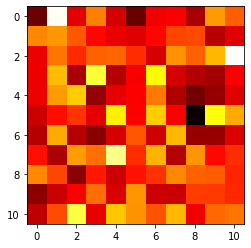

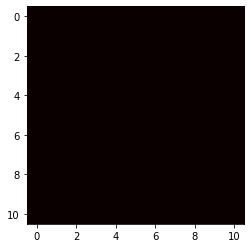

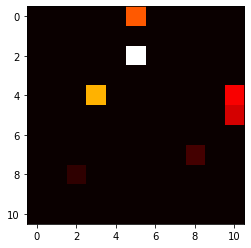

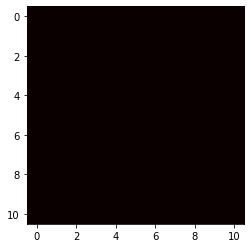

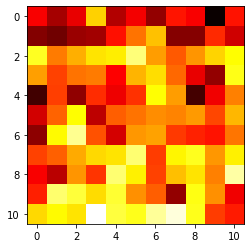

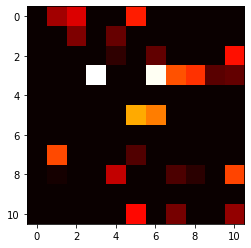

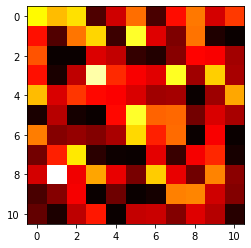

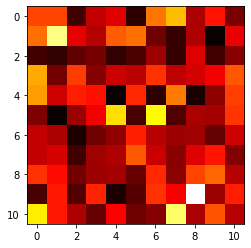

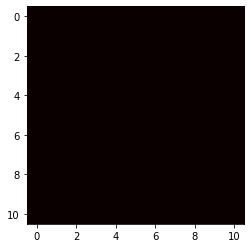

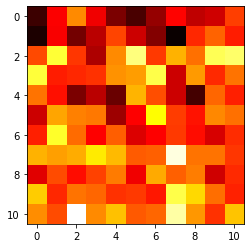

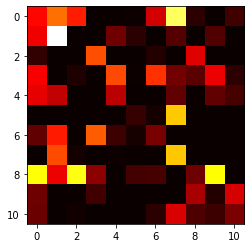

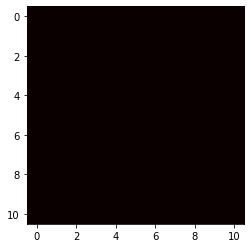

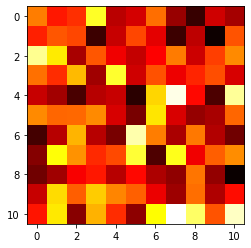

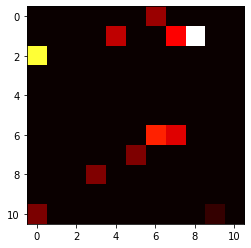

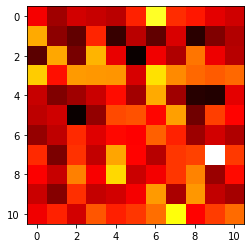

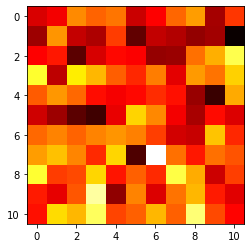

Label 7


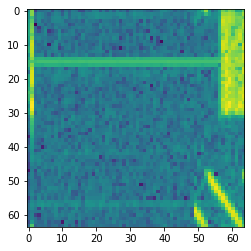

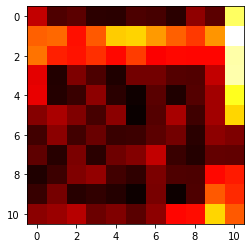

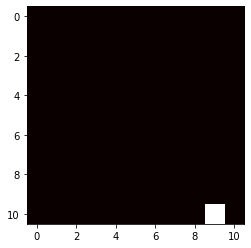

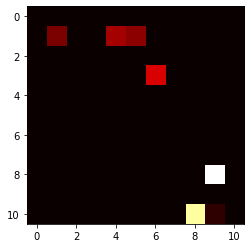

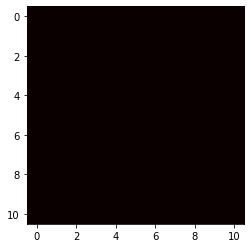

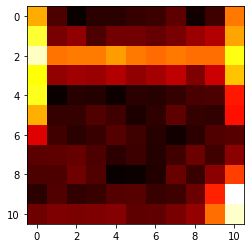

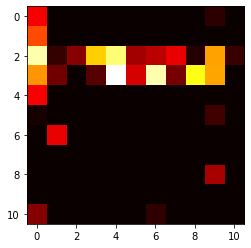

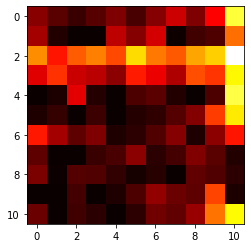

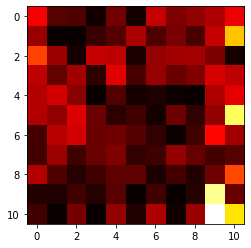

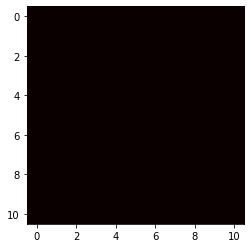

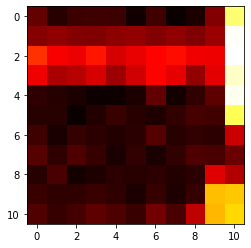

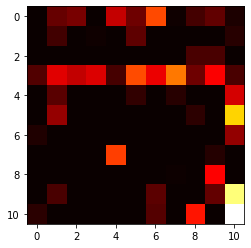

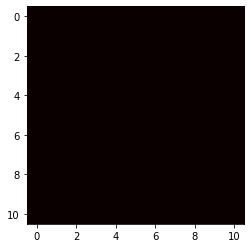

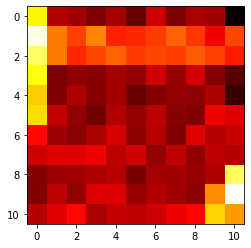

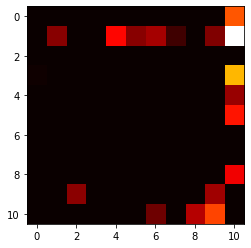

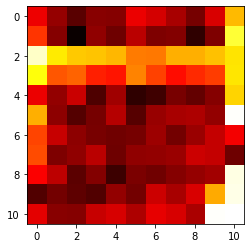

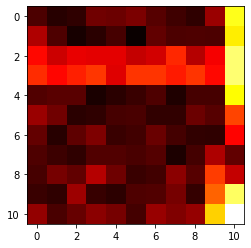

Label 8


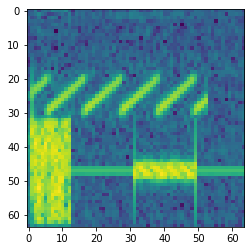

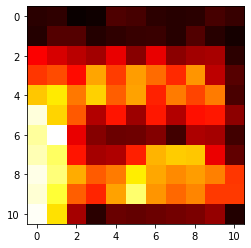

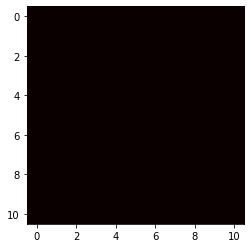

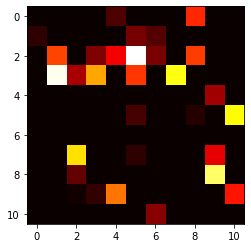

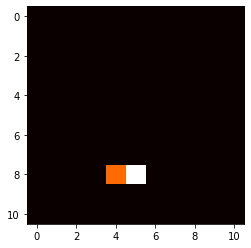

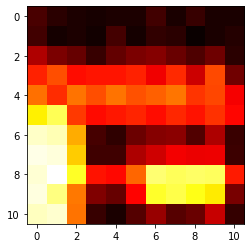

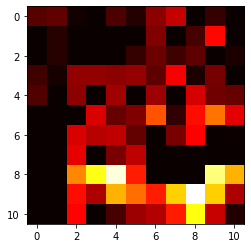

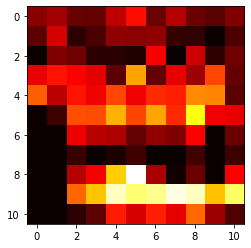

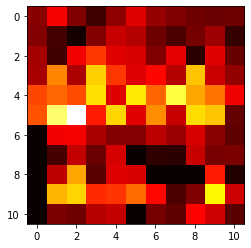

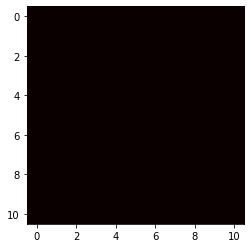

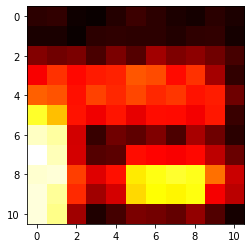

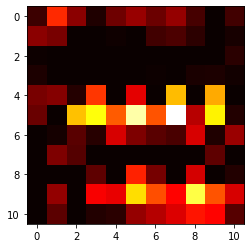

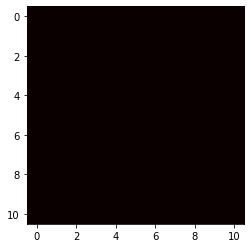

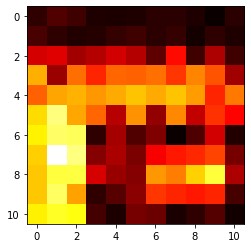

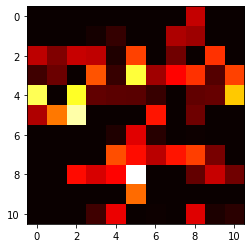

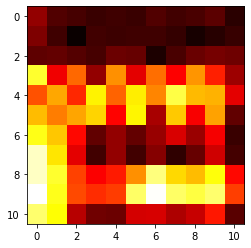

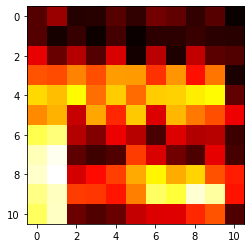

Label 9


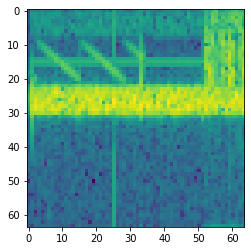

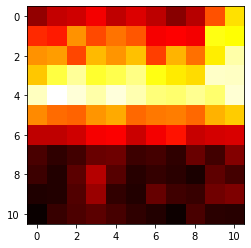

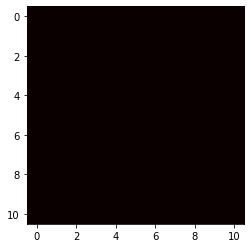

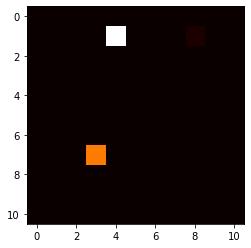

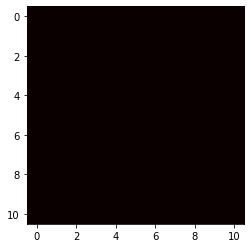

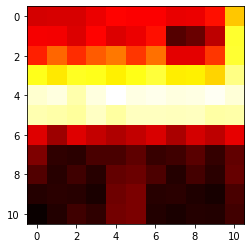

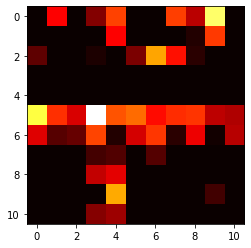

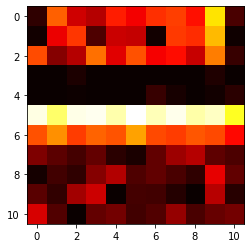

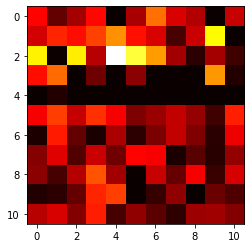

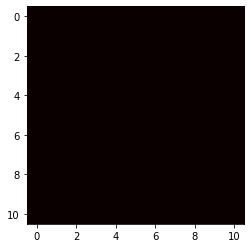

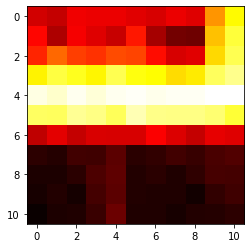

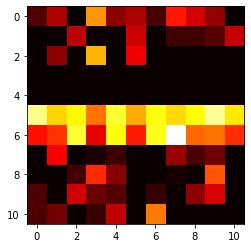

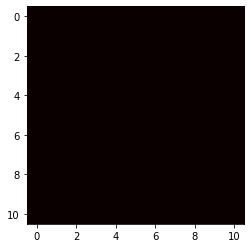

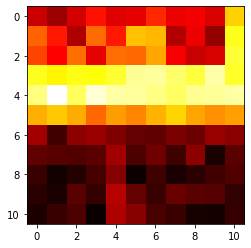

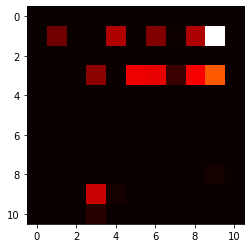

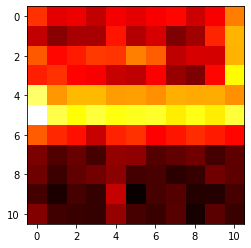

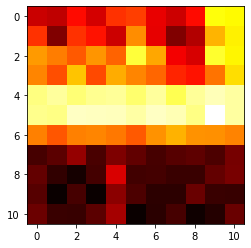

Label 10


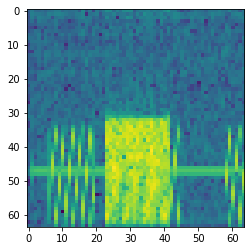

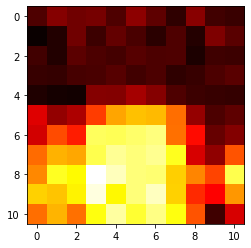

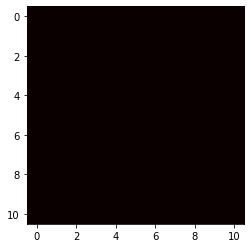

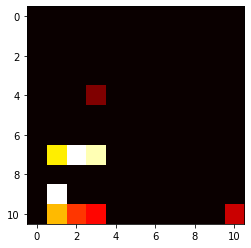

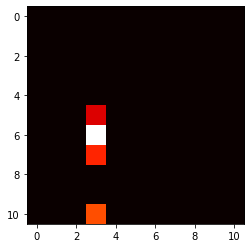

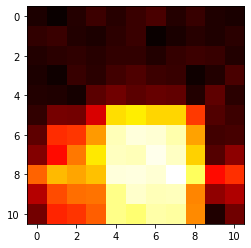

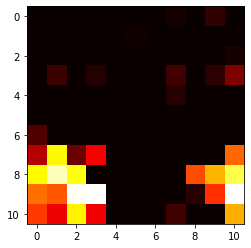

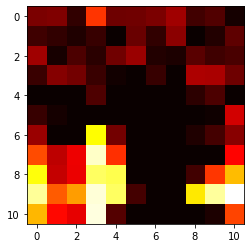

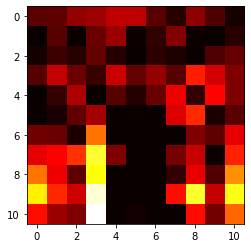

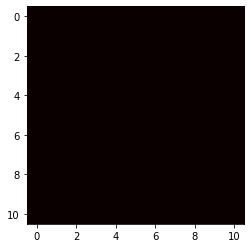

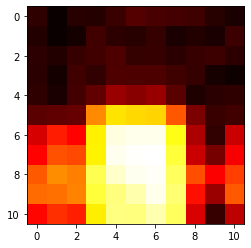

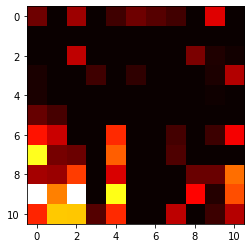

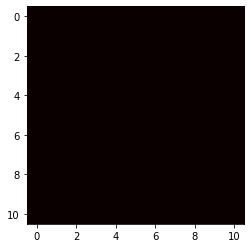

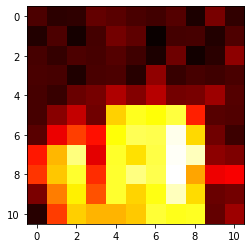

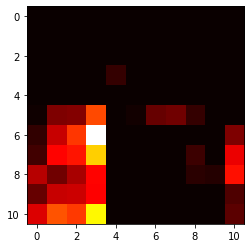

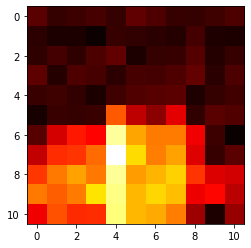

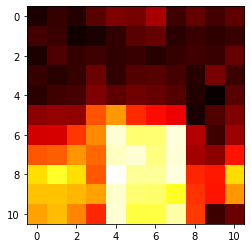

Label 11


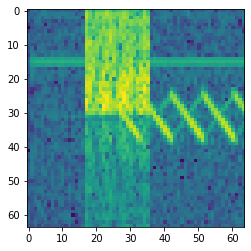

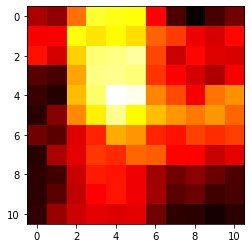

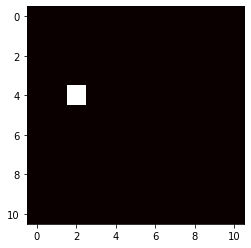

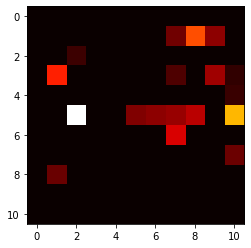

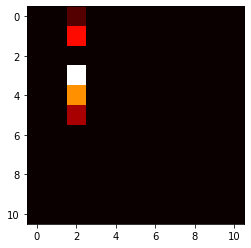

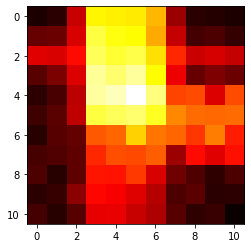

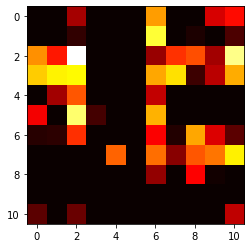

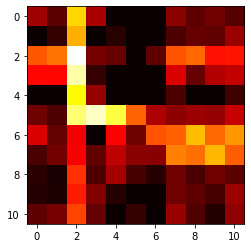

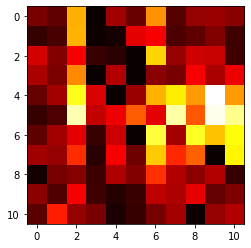

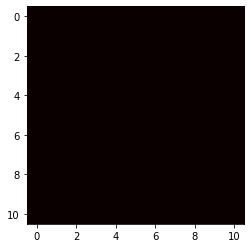

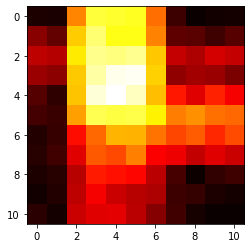

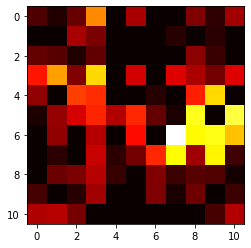

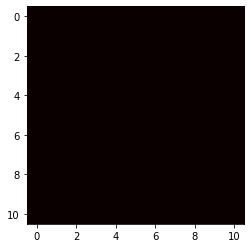

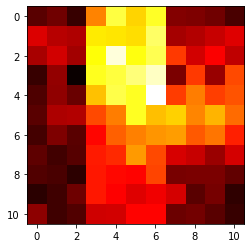

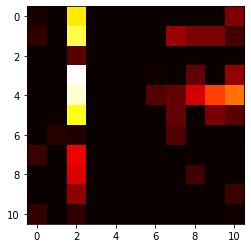

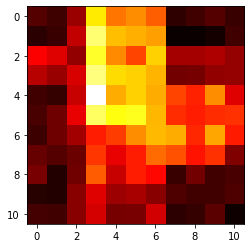

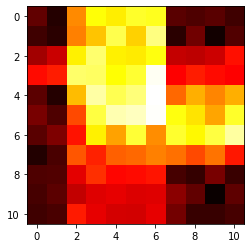

Label 12


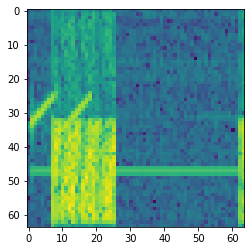

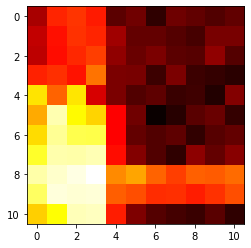

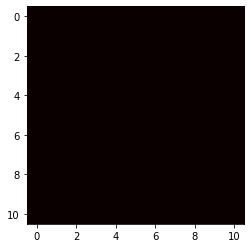

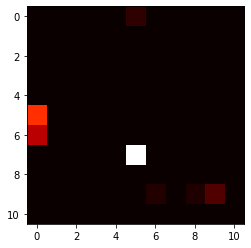

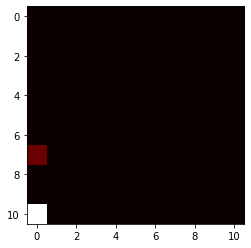

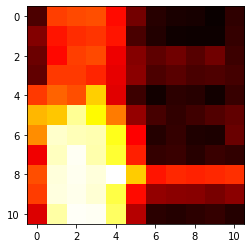

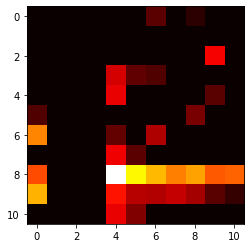

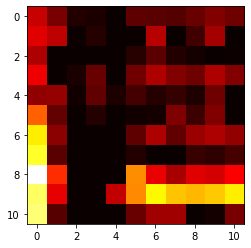

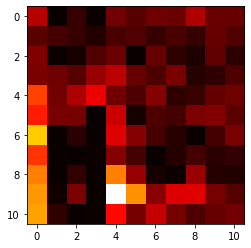

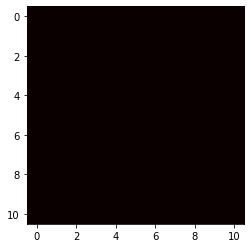

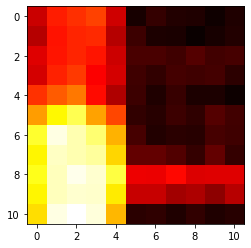

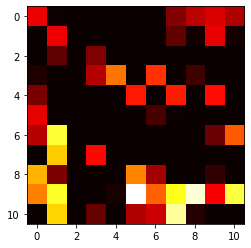

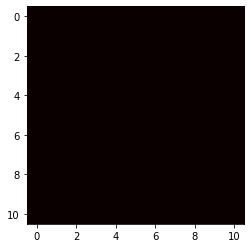

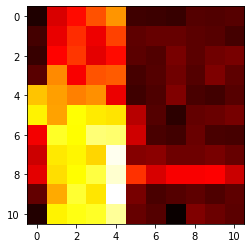

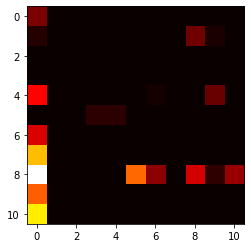

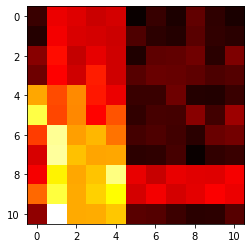

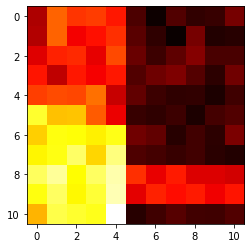

In [ ]:
for i in range(1,13): #new_20_eps model
  print("Label",i)
  # img1 = model(torch.from_numpy(spec_pool_by_label[i][0]).unsqueeze(0).unsqueeze(0).float())[1].reshape(10,10)
  # img2= model(torch.from_numpy(spec_pool_by_label[i][25]).unsqueeze(0).unsqueeze(0).float())[1].reshape(10,10)
  heatMaps= model(torch.from_numpy(spec_pool_by_label[i][0]).unsqueeze(0).unsqueeze(0).float())[0].squeeze(0)
  plot_image(spec_pool_by_label[i][0])
  for i in range(16):
    plot_heatmap(heatMaps[i].detach().numpy()) 

Label 1


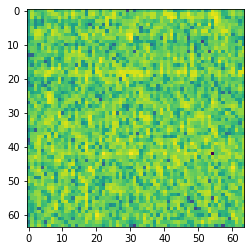

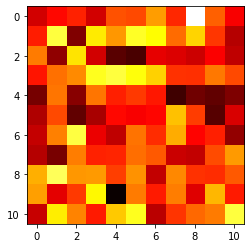

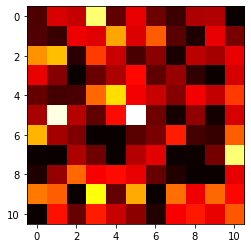

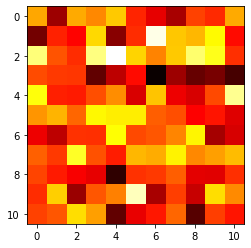

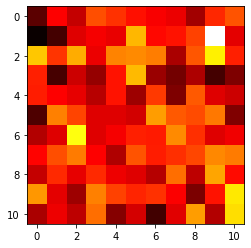

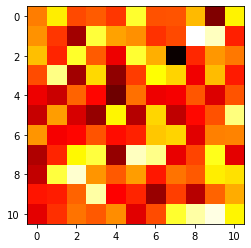

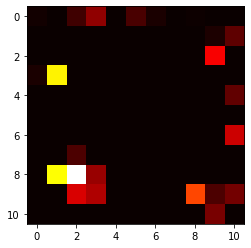

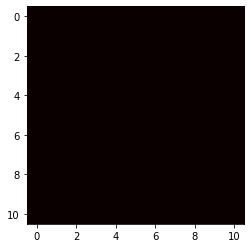

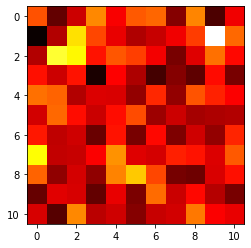

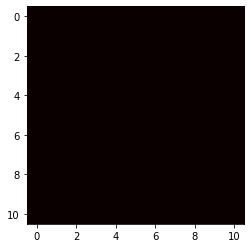

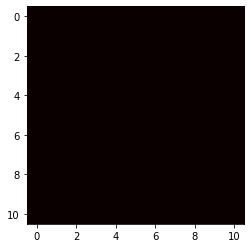

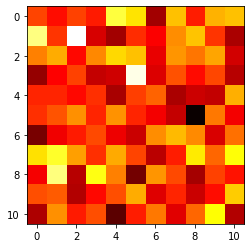

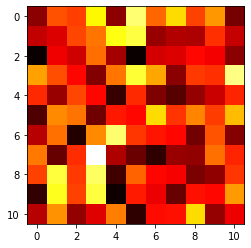

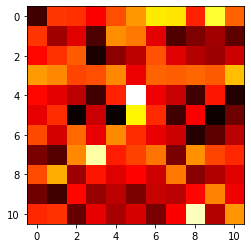

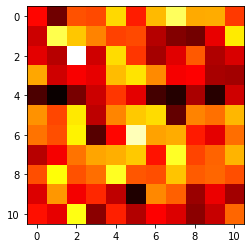

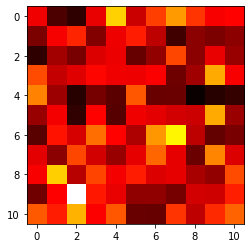

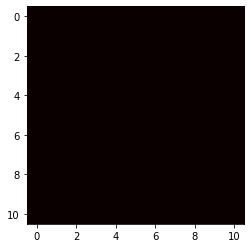

Label 2


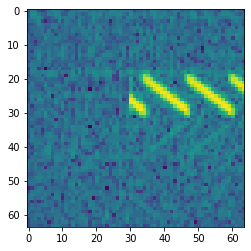

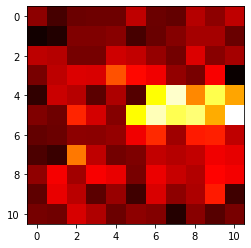

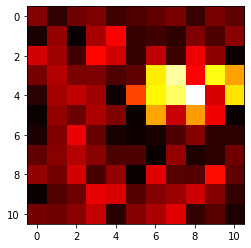

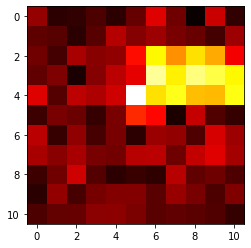

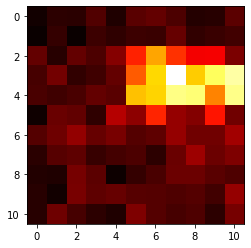

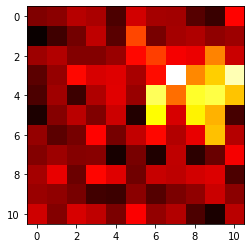

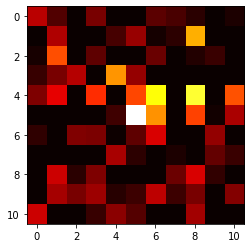

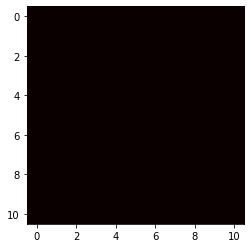

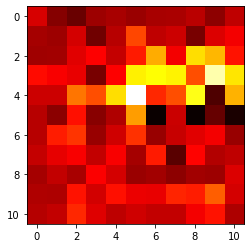

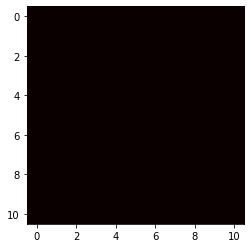

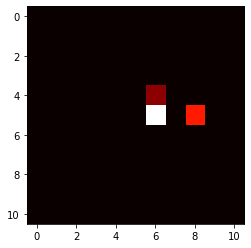

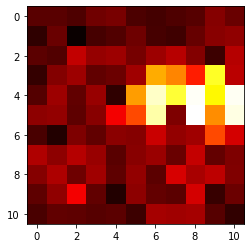

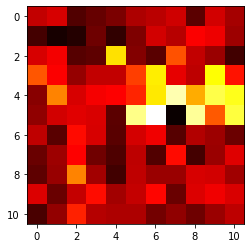

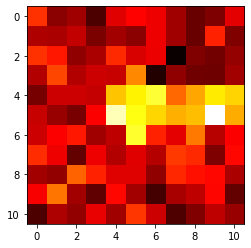

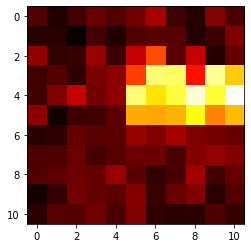

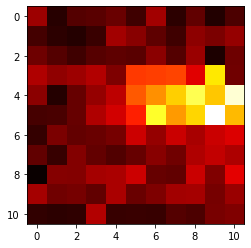

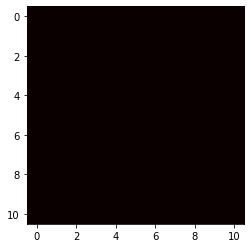

Label 3


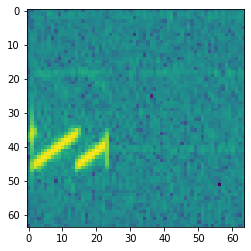

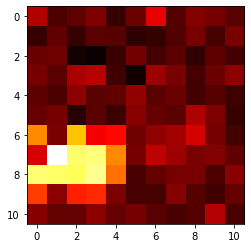

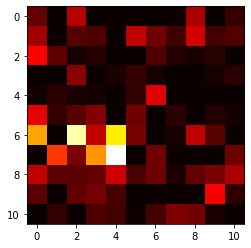

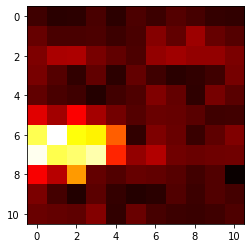

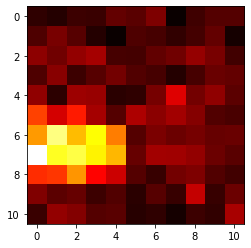

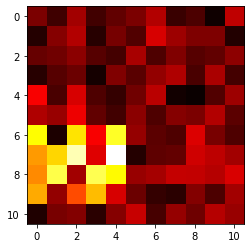

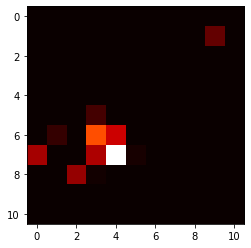

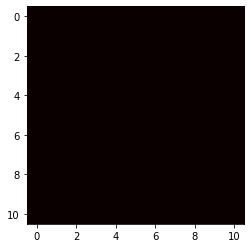

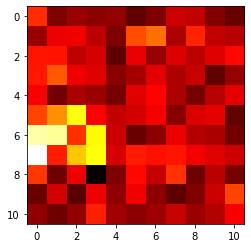

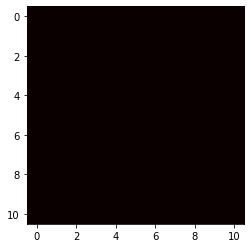

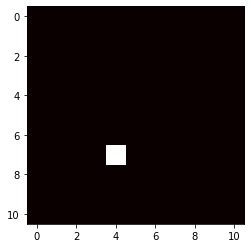

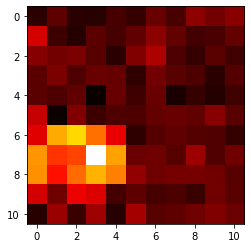

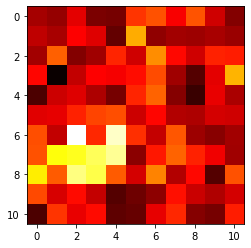

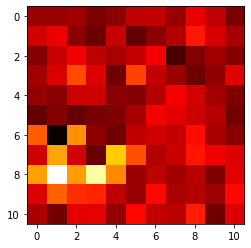

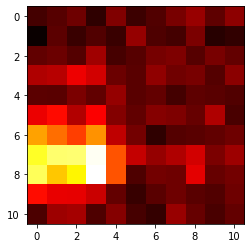

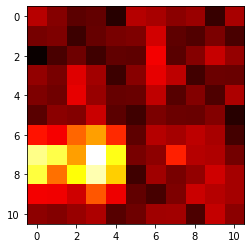

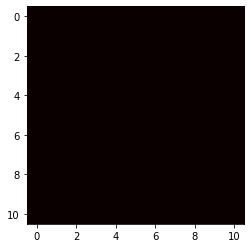

Label 4


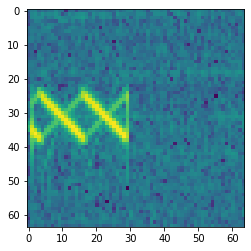

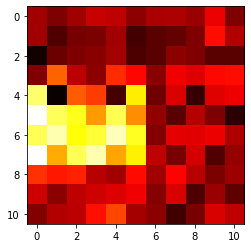

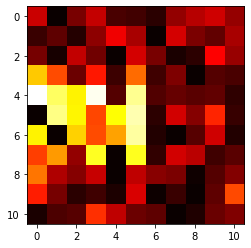

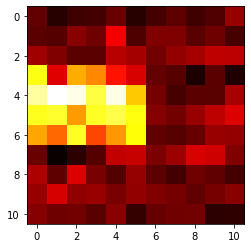

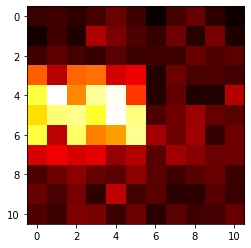

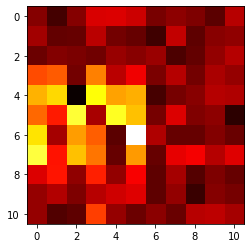

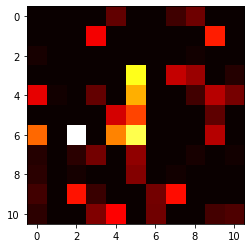

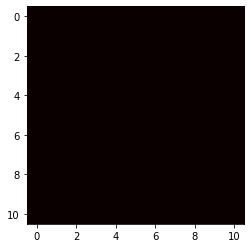

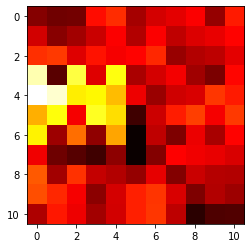

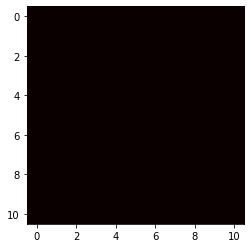

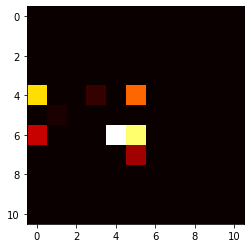

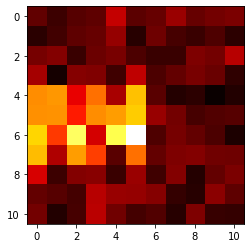

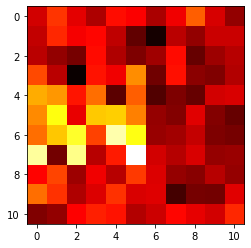

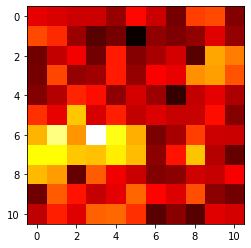

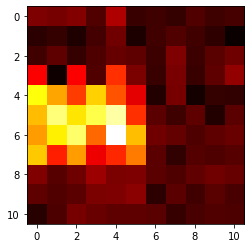

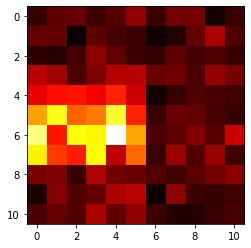

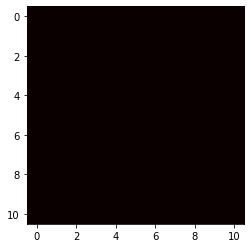

Label 5


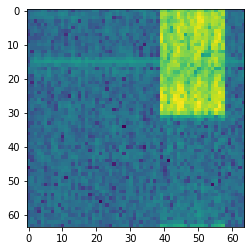

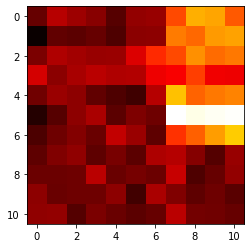

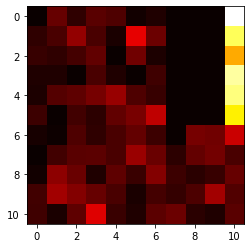

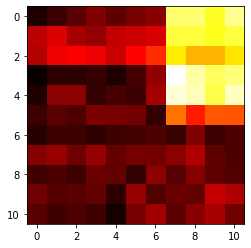

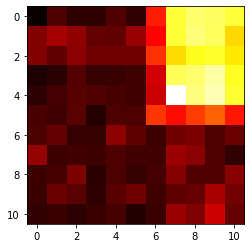

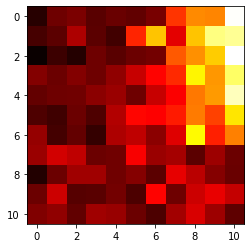

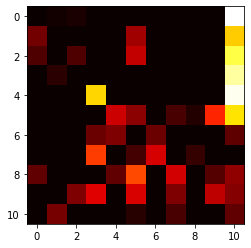

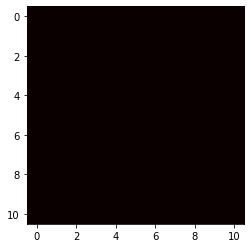

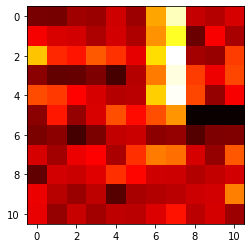

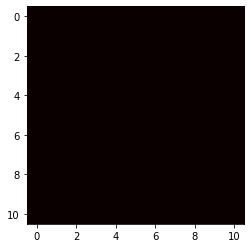

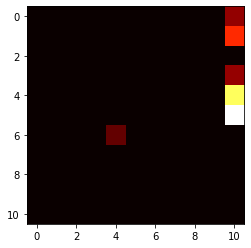

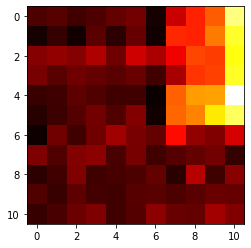

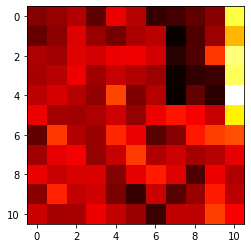

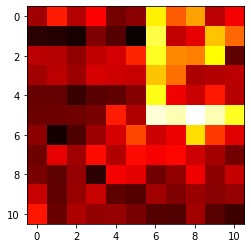

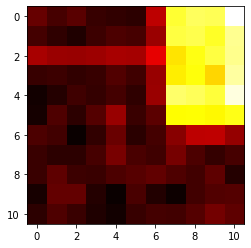

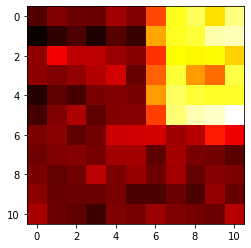

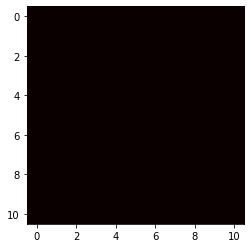

Label 6


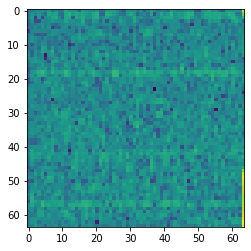

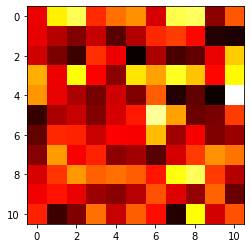

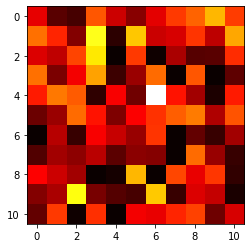

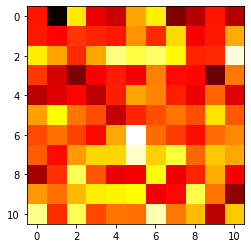

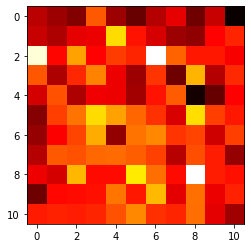

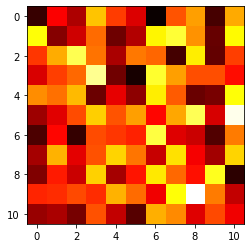

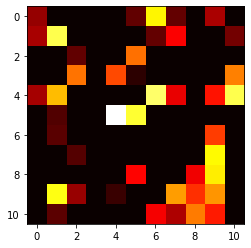

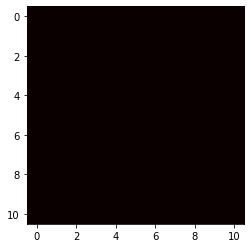

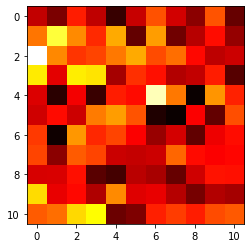

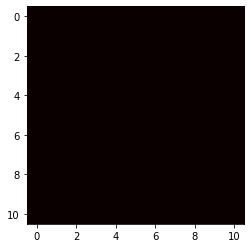

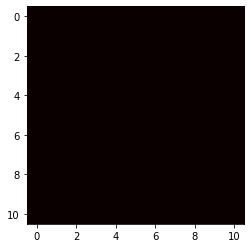

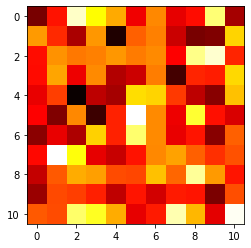

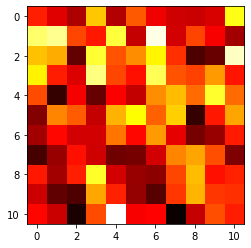

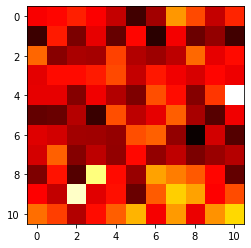

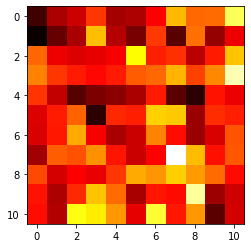

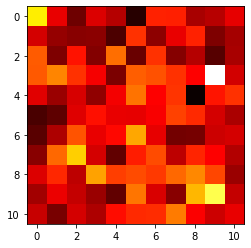

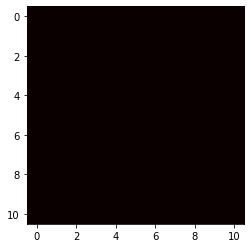

Label 7


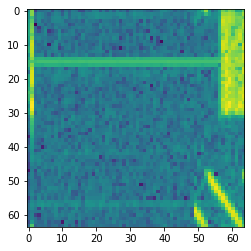

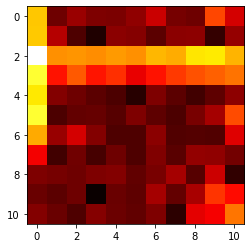

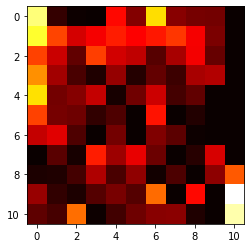

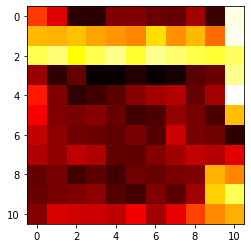

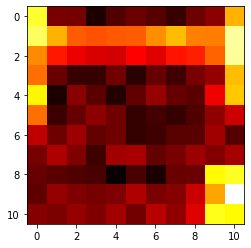

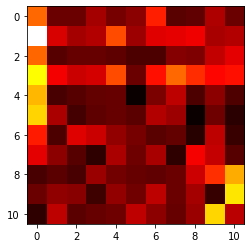

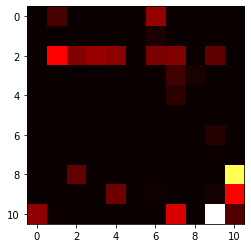

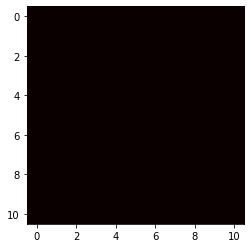

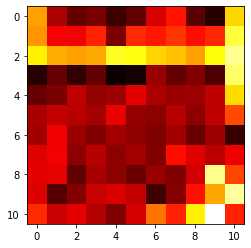

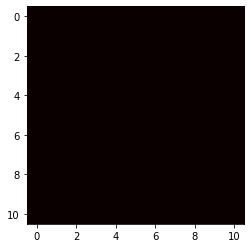

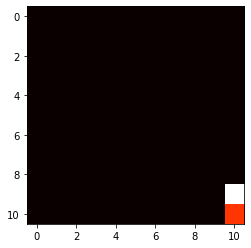

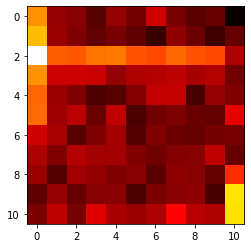

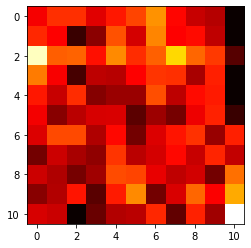

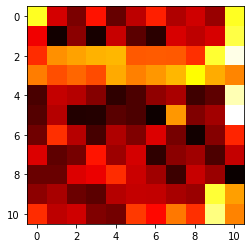

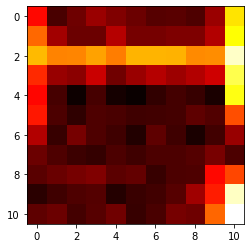

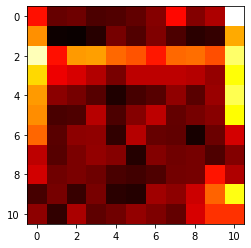

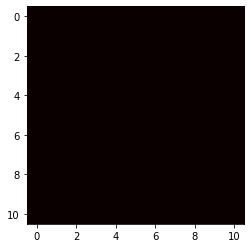

Label 8


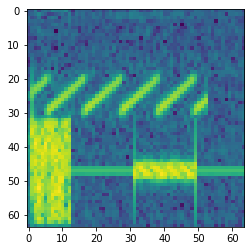

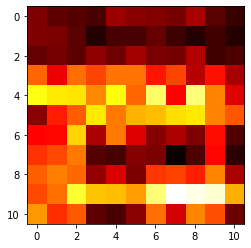

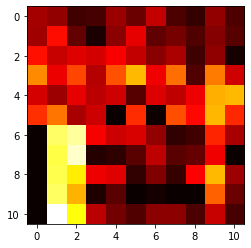

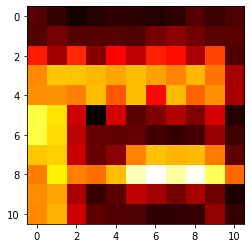

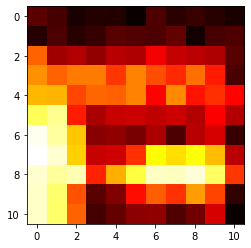

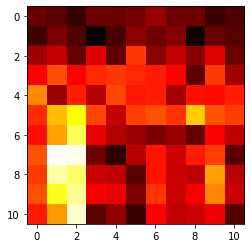

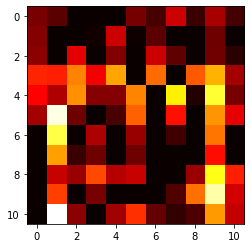

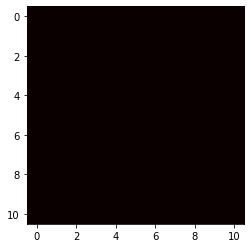

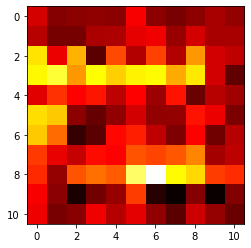

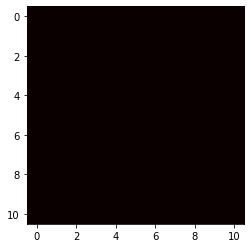

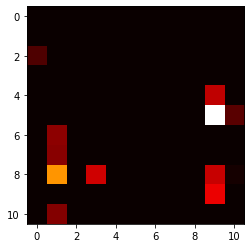

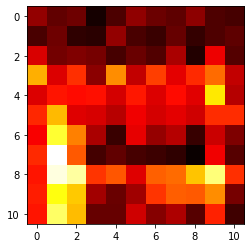

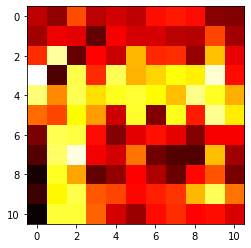

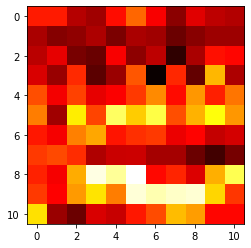

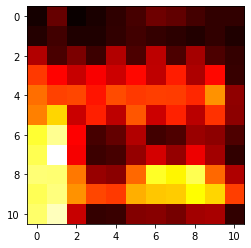

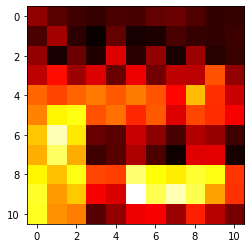

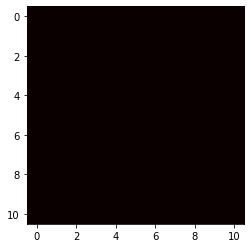

Label 9


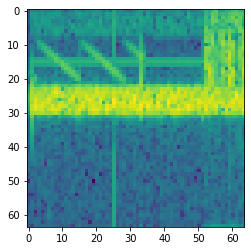

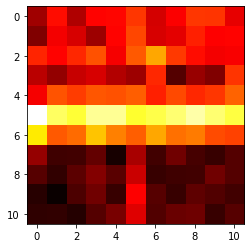

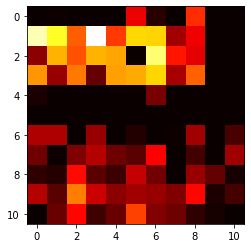

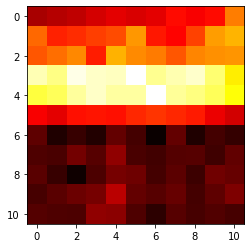

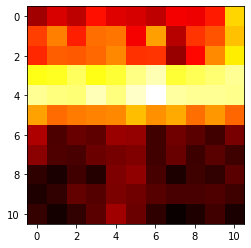

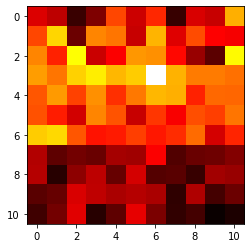

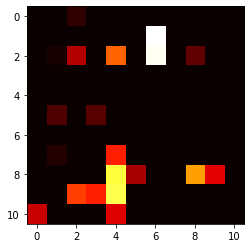

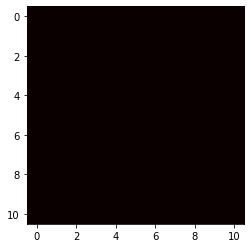

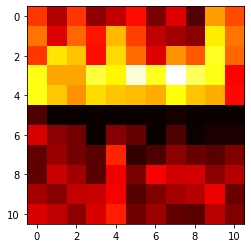

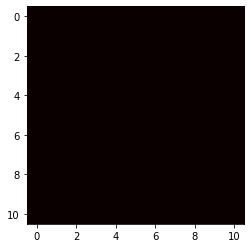

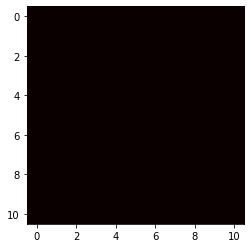

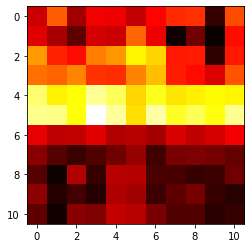

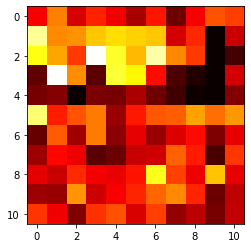

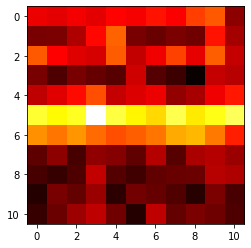

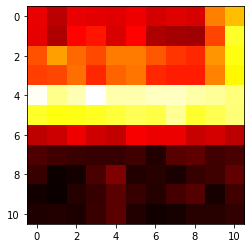

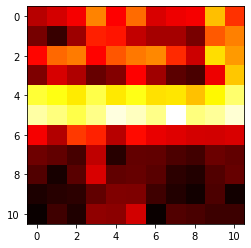

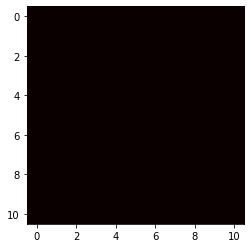

Label 10


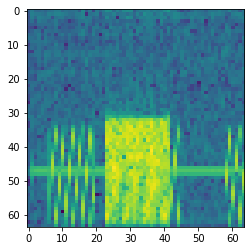

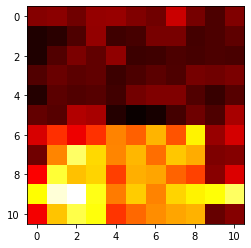

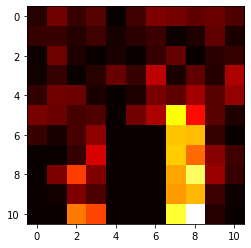

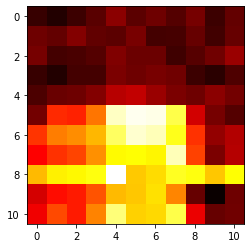

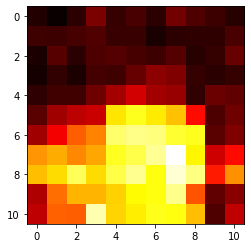

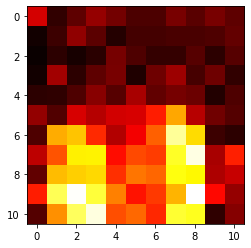

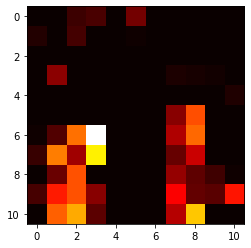

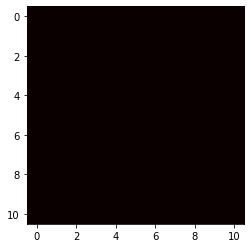

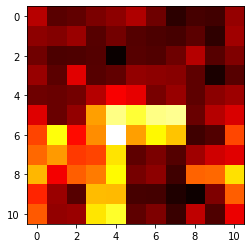

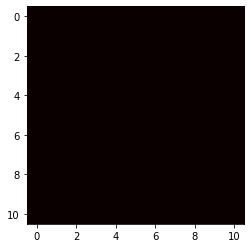

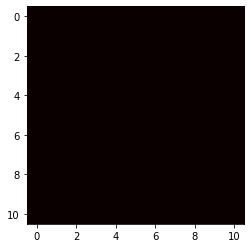

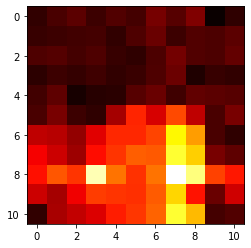

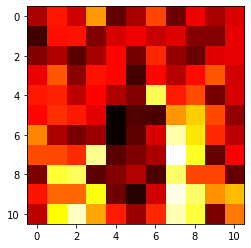

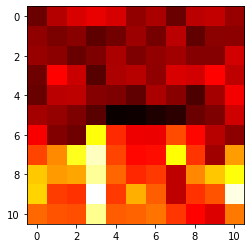

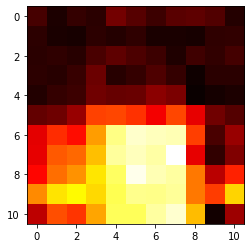

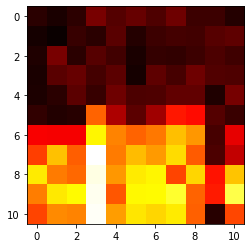

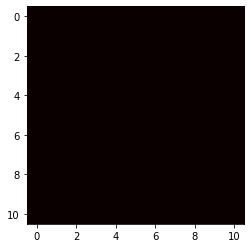

Label 11


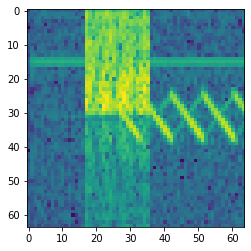

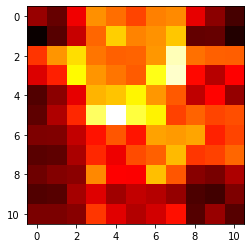

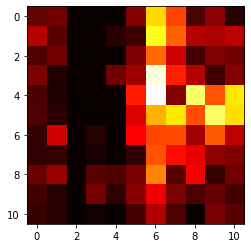

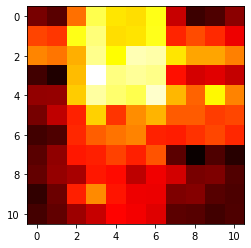

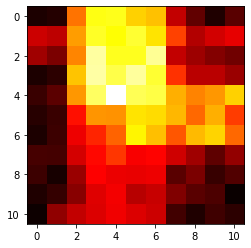

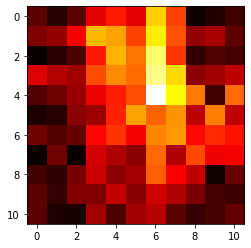

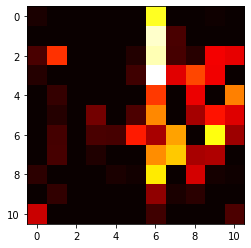

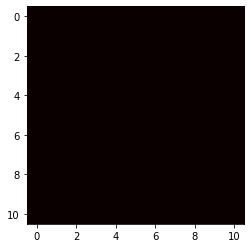

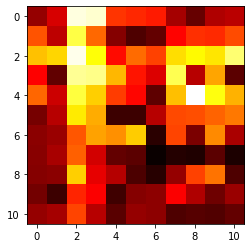

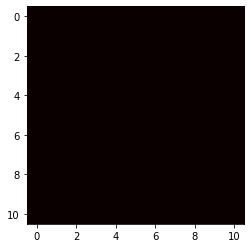

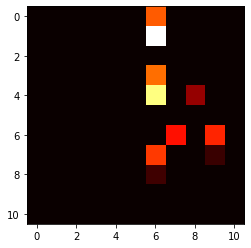

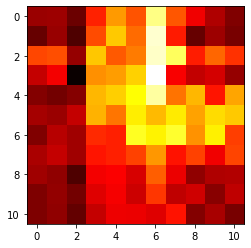

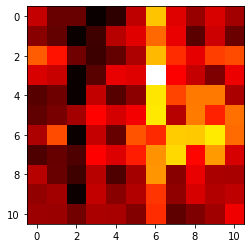

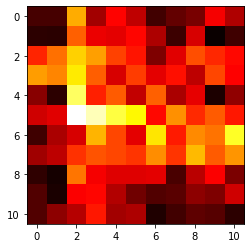

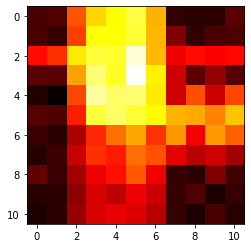

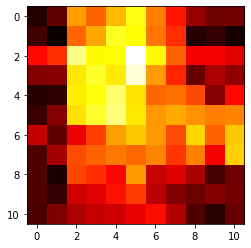

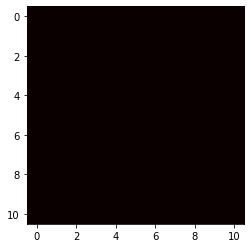

Label 12


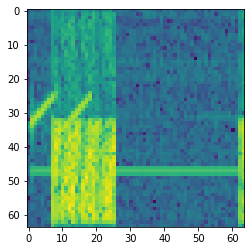

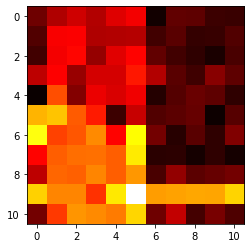

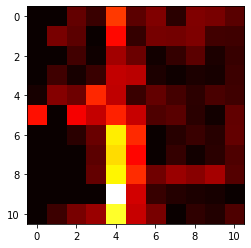

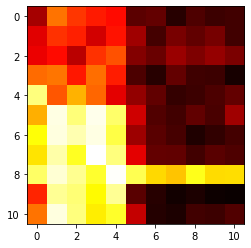

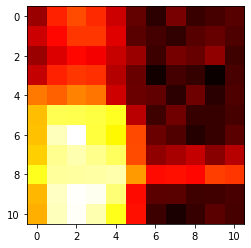

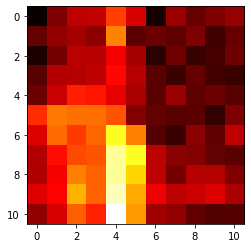

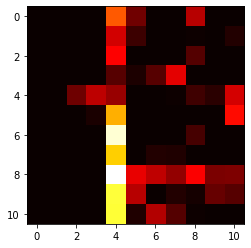

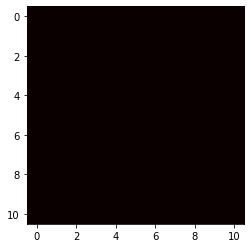

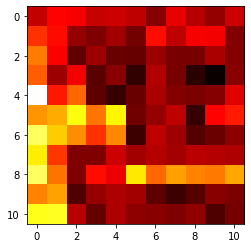

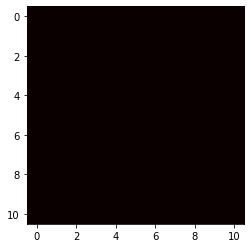

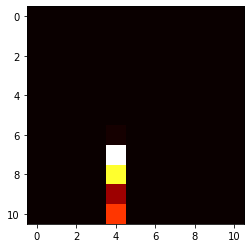

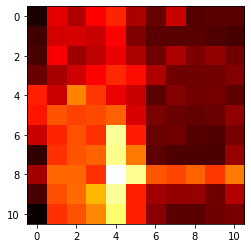

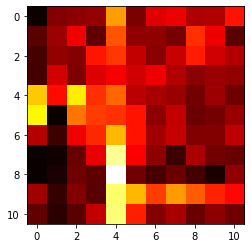

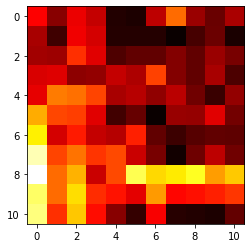

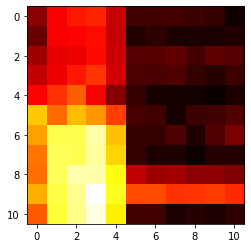

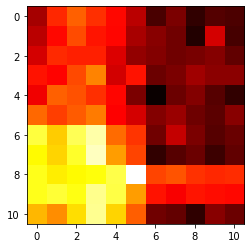

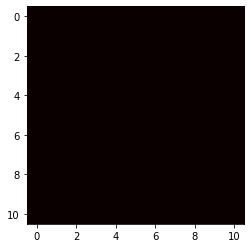

In [ ]:
for i in range(1,13): #new_50_eps model
  print("Label",i)
  heatMaps= model(torch.from_numpy(spec_pool_by_label[i][0]).unsqueeze(0).unsqueeze(0).float())[0].squeeze(0)
  plot_image(spec_pool_by_label[i][0])
  for i in range(16):
    plot_heatmap(heatMaps[i].detach().numpy()) 

Validation data activation maps

Label 6


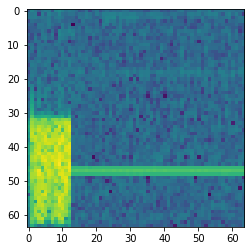

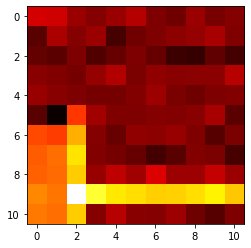

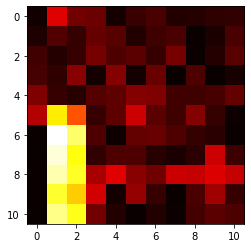

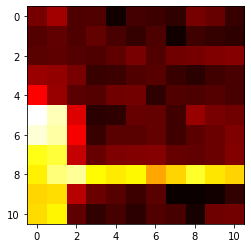

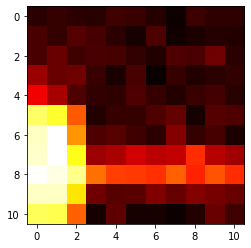

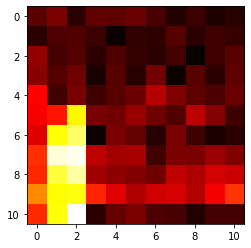

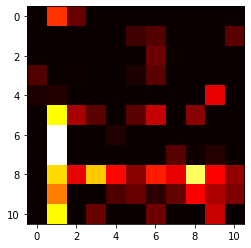

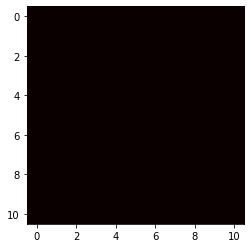

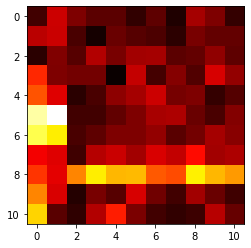

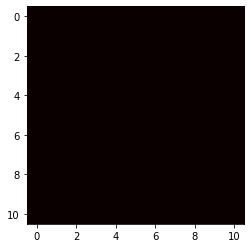

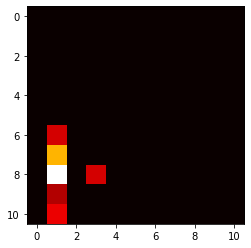

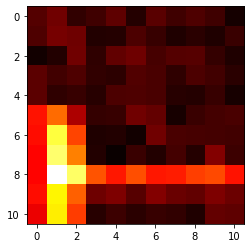

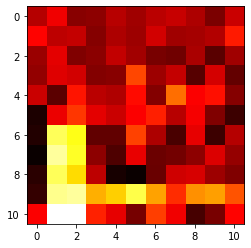

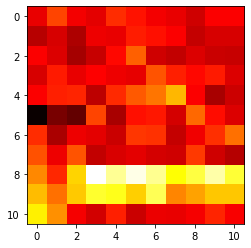

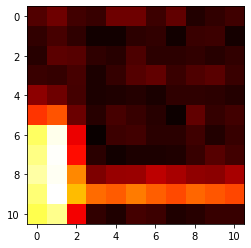

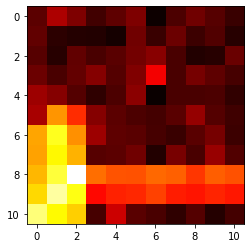

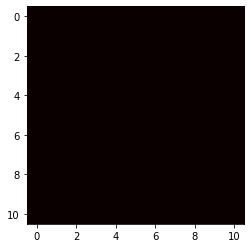

Label 7


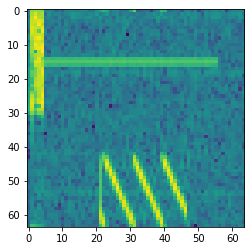

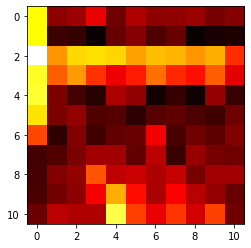

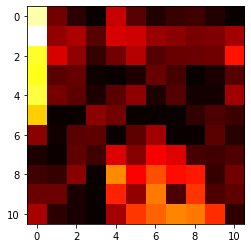

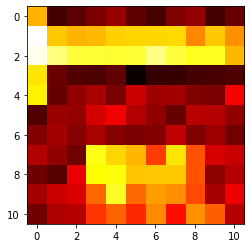

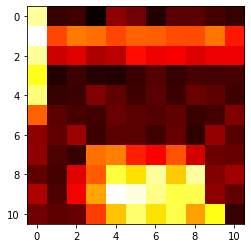

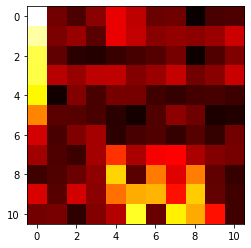

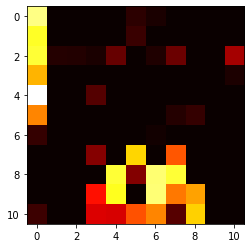

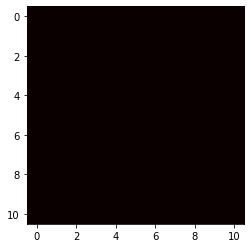

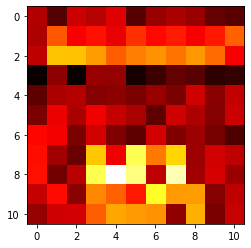

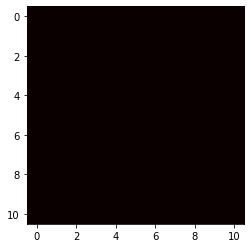

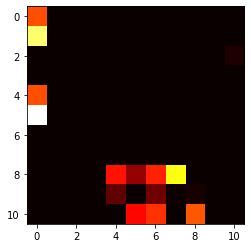

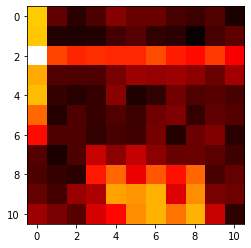

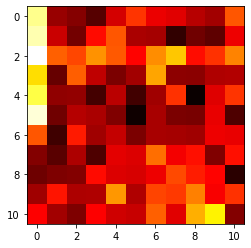

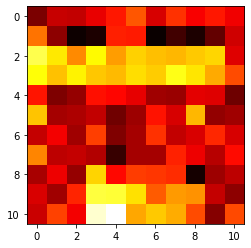

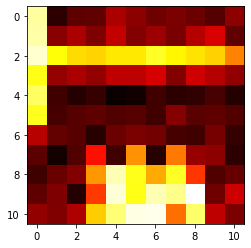

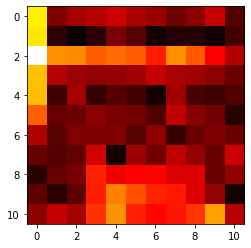

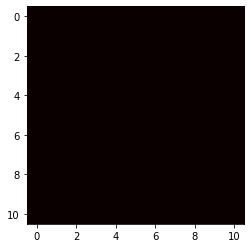

Label 12


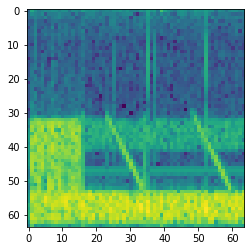

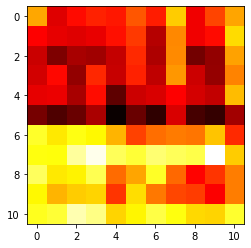

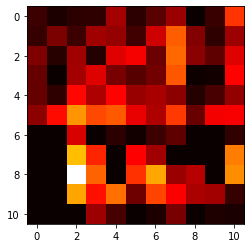

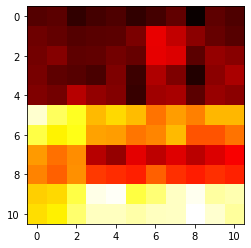

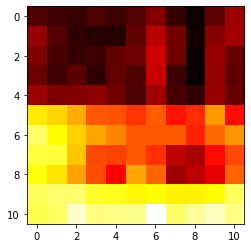

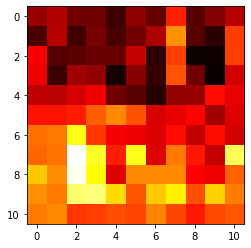

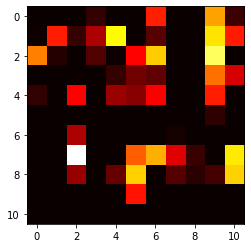

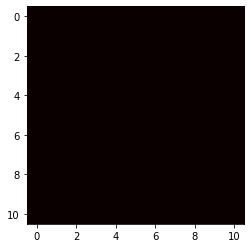

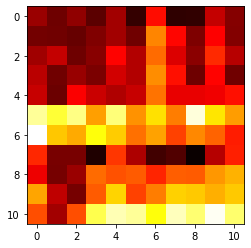

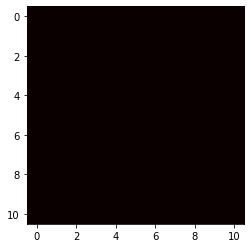

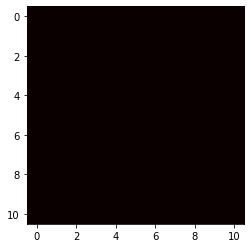

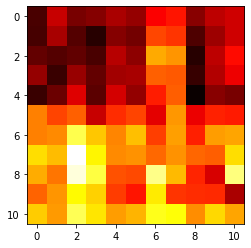

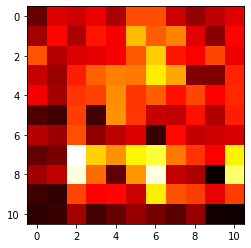

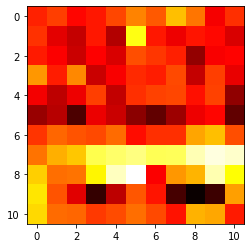

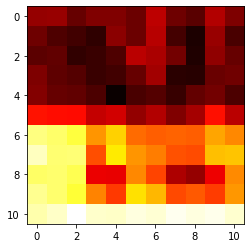

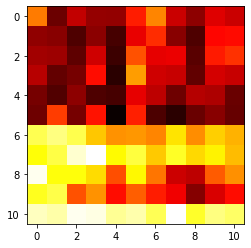

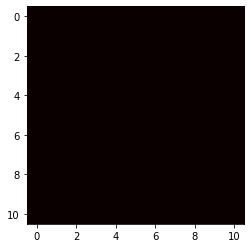

Label 6


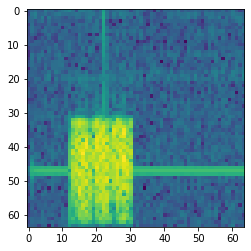

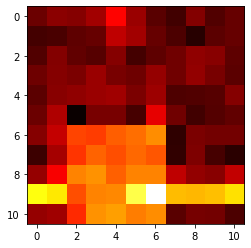

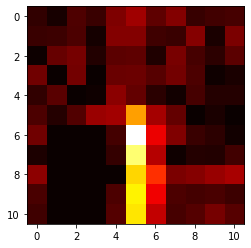

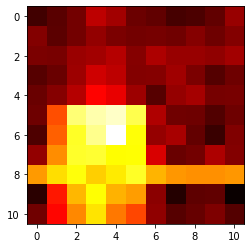

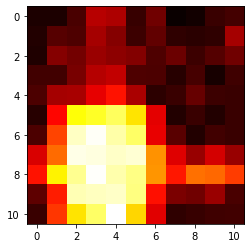

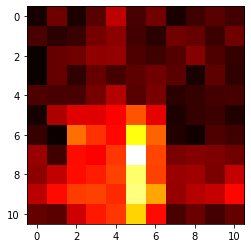

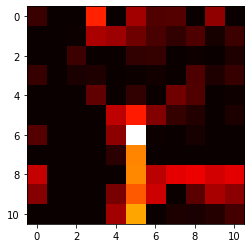

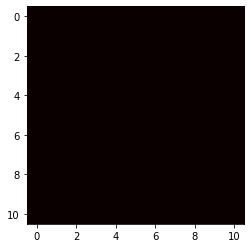

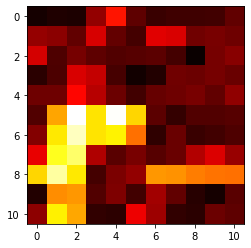

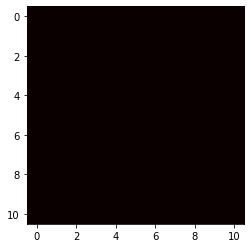

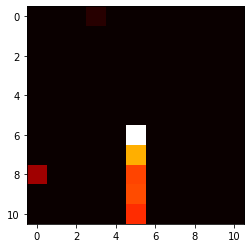

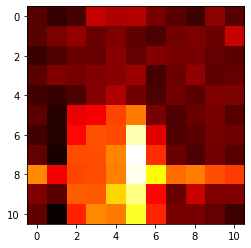

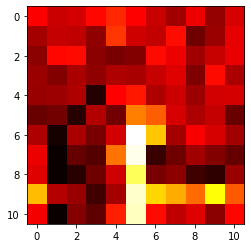

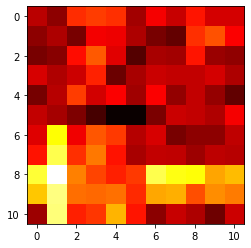

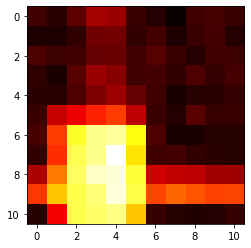

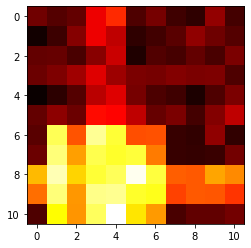

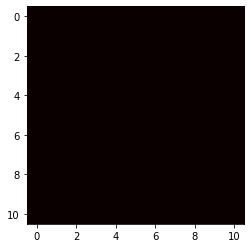

Label 8


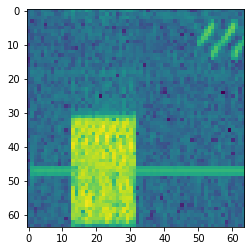

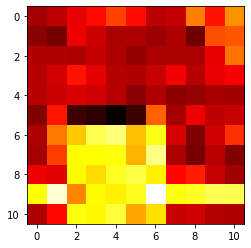

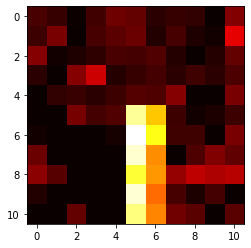

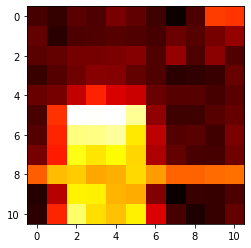

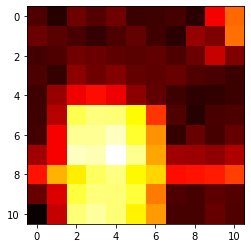

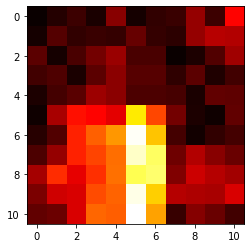

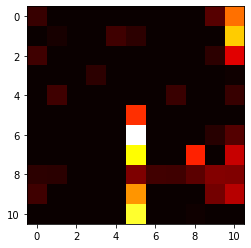

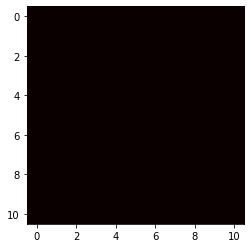

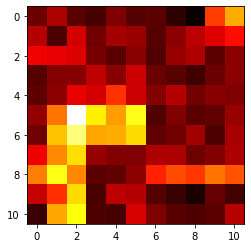

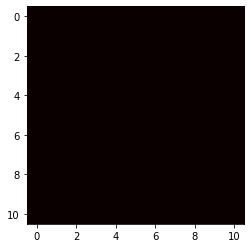

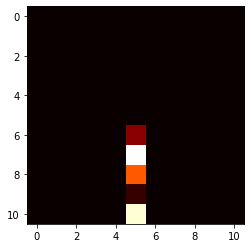

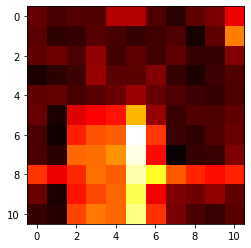

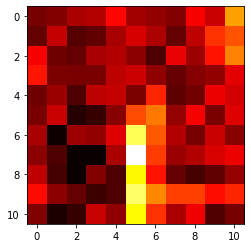

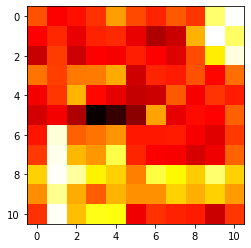

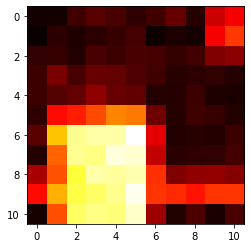

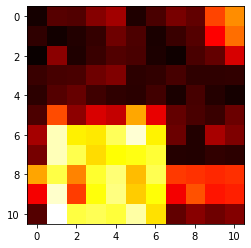

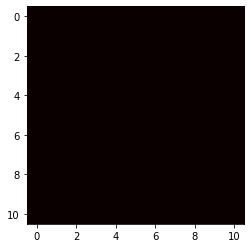

In [ ]:
for i in range(5): 
  print("Label",test_y[i])
  test_data_preds=model(torch.from_numpy(test_data[i]).unsqueeze(0).unsqueeze(0).float())[0].squeeze(0).detach().numpy()
  plot_image(test_data[i])
  for j in range(16):
    plot_heatmap(test_data_preds[j]) 

Validation of learned features: RandomForest Classifier

In [ ]:
SAMPLES = 30000
VAL_SAMPLES = len(dataset)-SAMPLES

In [ ]:
data = []

for i in range(SAMPLES):
    data.append(
        np.array(
                np.asarray(dataset[i][random.randint(0,49)]) #first chooses a datapoint and then randomly selects a frame from the (K=)50 frames associated with the label

        )
    )

In [ ]:
data_original = [data[i].flatten() for i in range(SAMPLES)] #CONTROL

In [ ]:
test_data_original = [test_data[i].flatten() for i in range(VAL_SAMPLES)]

In [ ]:
y=choices_labels[:SAMPLES]
test_y = choices_labels[SAMPLES:SAMPLES+VAL_SAMPLES]

In [ ]:
#changing labels to Radar-1/No_Radar-0
R=(2,3,4,7,8,9,10,11,12)
NR=(1,5,6)

In [ ]:
# new_y = [0 if label in NR else 1 for label in y]
# new_test_y = [0 if label in NR else 1 for label in test_y]

In [ ]:
test_data = []
for i in range(SAMPLES,SAMPLES+VAL_SAMPLES):
    test_data.append(
        np.array(
                np.asarray(dataset[i][random.randint(0,49)]) #first chooses a datapoint and then randomly selects a frame from the (K=)50 frames associated with the label

        )
    )



In [ ]:
test_data[0].shape

(64, 64)

Checkpoint


In [ ]:
model(torch.from_numpy(data[0]).unsqueeze(0).unsqueeze(0).float())[0].squeeze(0).flatten().shape #=1936

torch.Size([1936])

In [ ]:
data_reduced = [model(torch.from_numpy(data[i]).unsqueeze(0).unsqueeze(0).float())[0].squeeze(0).flatten().detach().numpy() for i in range(SAMPLES)]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=30, random_state=42)
# clf.fit(data_reduced, new_y)
# clf.fit(data_reduced, y)
clf.fit(data_original, y)

RandomForestClassifier(max_depth=30, random_state=42)

In [ ]:
test_data_reduced = [model(torch.from_numpy(test_data[i]).unsqueeze(0).unsqueeze(0).float())[0].squeeze(0).flatten().detach().numpy() for i in range(VAL_SAMPLES)]

In [ ]:
from sklearn.metrics import classification_report #old_20_eps model
print(classification_report(test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       0.97      1.00      0.98      4091
           2       0.95      0.94      0.95       610
           3       0.96      0.96      0.96       424
           4       1.00      0.06      0.11        53
           5       0.94      0.98      0.96      1612
           6       0.94      0.99      0.96      1472
           7       0.99      0.87      0.92       153
           8       0.94      0.85      0.89       223
           9       1.00      0.53      0.69       179
          10       1.00      0.56      0.72       144
          11       1.00      0.05      0.10        19
          12       1.00      0.05      0.10        20

    accuracy                           0.96      9000
   macro avg       0.97      0.65      0.70      9000
weighted avg       0.96      0.96      0.95      9000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


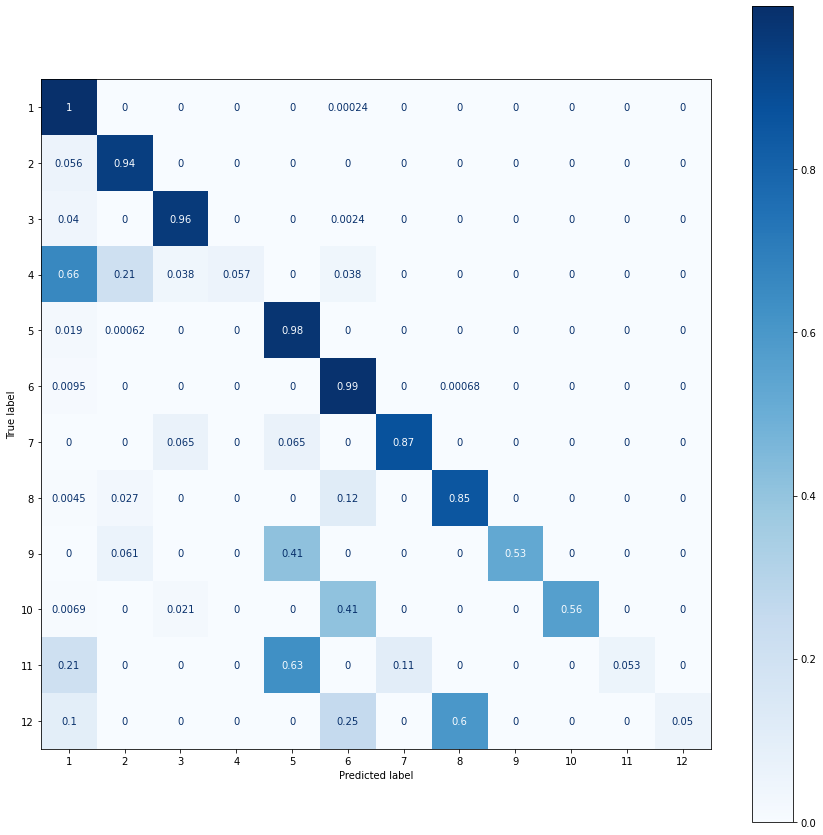

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, test_data_reduced, test_y, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report #new_20_eps model
print(classification_report(test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4133
           2       0.97      1.00      0.98       568
           3       0.97      1.00      0.99       388
           4       0.95      0.65      0.77        55
           5       0.96      1.00      0.98      1623
           6       0.96      1.00      0.98      1513
           7       0.97      0.94      0.96       161
           8       0.94      0.93      0.93       209
           9       0.99      0.67      0.80       168
          10       0.98      0.66      0.79       151
          11       1.00      0.08      0.15        12
          12       1.00      0.05      0.10        19

    accuracy                           0.98      9000
   macro avg       0.97      0.75      0.79      9000
weighted avg       0.98      0.98      0.98      9000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


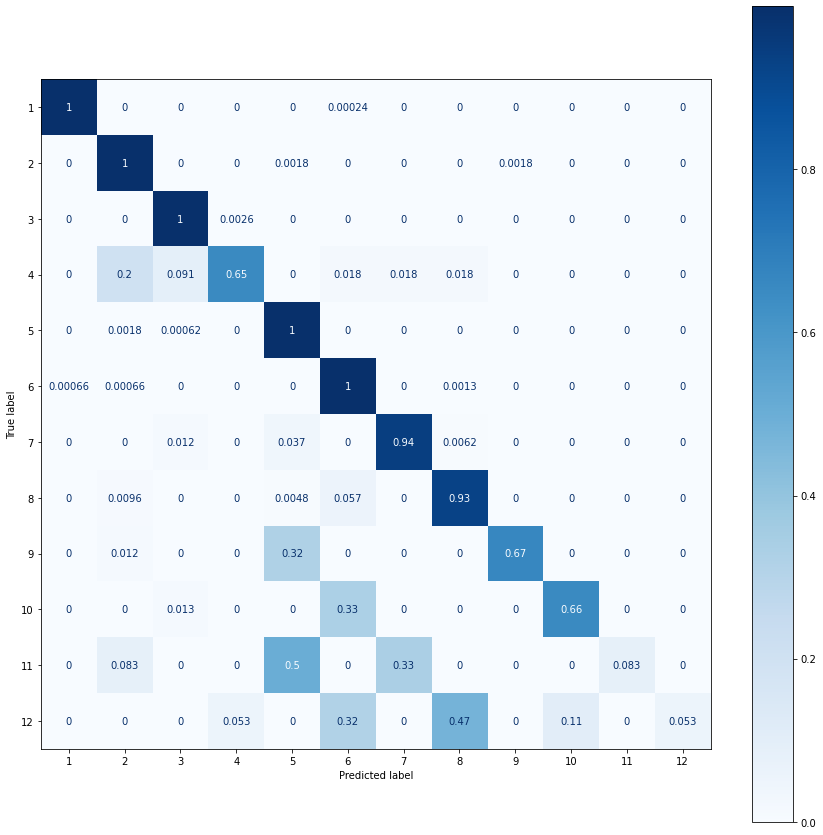

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, test_data_reduced, test_y, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report #new_30_eps model
print(classification_report(test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4133
           2       0.96      1.00      0.98       568
           3       0.97      1.00      0.98       388
           4       0.97      0.71      0.82        55
           5       0.96      1.00      0.98      1623
           6       0.96      1.00      0.98      1513
           7       0.98      0.94      0.96       161
           8       0.94      0.91      0.92       209
           9       1.00      0.64      0.78       168
          10       1.00      0.68      0.81       151
          11       1.00      0.17      0.29        12
          12       1.00      0.05      0.10        19

    accuracy                           0.98      9000
   macro avg       0.98      0.76      0.80      9000
weighted avg       0.98      0.98      0.98      9000



In [ ]:
from sklearn.metrics import classification_report #new_10_eps model
print(classification_report(test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4133
           2       0.97      1.00      0.98       568
           3       0.97      1.00      0.98       388
           4       0.95      0.67      0.79        55
           5       0.96      1.00      0.98      1623
           6       0.95      1.00      0.97      1513
           7       0.98      0.93      0.96       161
           8       0.92      0.92      0.92       209
           9       1.00      0.63      0.77       168
          10       1.00      0.64      0.78       151
          11       1.00      0.17      0.29        12
          12       1.00      0.05      0.10        19

    accuracy                           0.98      9000
   macro avg       0.97      0.75      0.79      9000
weighted avg       0.98      0.98      0.97      9000



In [ ]:
from sklearn.metrics import classification_report #new_50_eps model
print(classification_report(test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4133
           2       0.96      1.00      0.98       568
           3       0.97      1.00      0.98       388
           4       0.97      0.62      0.76        55
           5       0.96      1.00      0.98      1623
           6       0.95      1.00      0.97      1513
           7       0.97      0.94      0.96       161
           8       0.94      0.91      0.92       209
           9       0.99      0.64      0.78       168
          10       1.00      0.65      0.79       151
          11       1.00      0.08      0.15        12
          12       1.00      0.11      0.19        19

    accuracy                           0.98      9000
   macro avg       0.98      0.74      0.79      9000
weighted avg       0.98      0.98      0.97      9000



In [ ]:
from sklearn.metrics import classification_report #new_50_eps model - with data balancing
print(classification_report(test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       542
           2       0.98      1.00      0.99       526
           3       0.98      1.00      0.99       609
           4       0.99      0.99      0.99       556
           5       0.99      0.99      0.99       570
           6       0.99      0.97      0.98       594
           7       1.00      0.99      1.00       575
           8       1.00      0.98      0.99       579
           9       0.99      0.99      0.99       544
          10       0.99      1.00      0.99       612
          11       1.00      1.00      1.00       558
          12       1.00      1.00      1.00       589

    accuracy                           0.99      6854
   macro avg       0.99      0.99      0.99      6854
weighted avg       0.99      0.99      0.99      6854



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


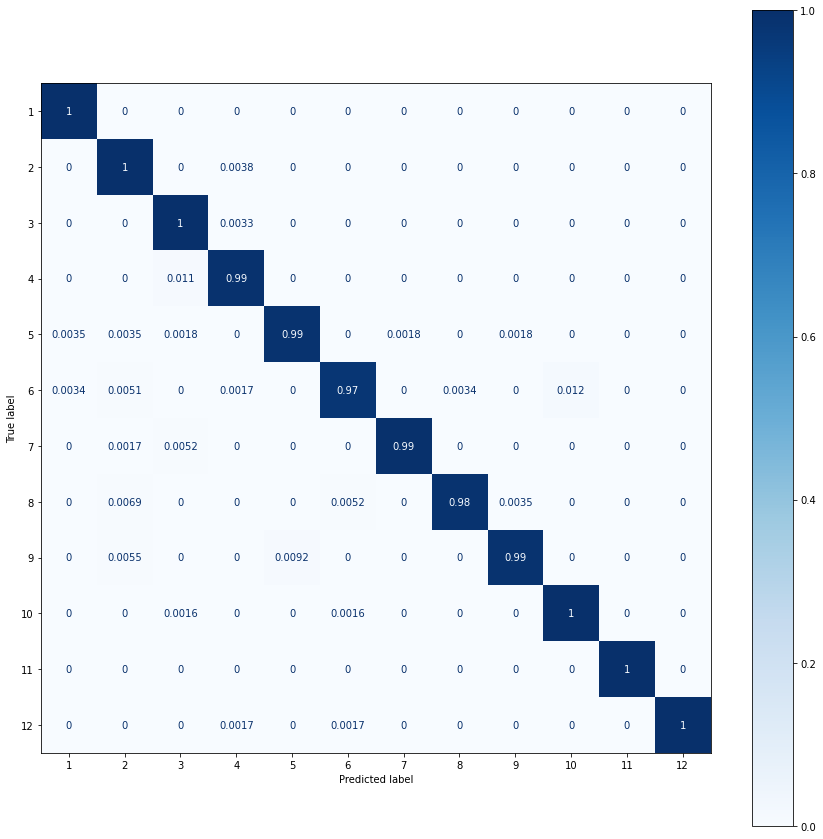

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, test_data_reduced, test_y, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report #original - with data balancing
print(classification_report(test_y, clf.predict(test_data_original))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       596
           2       0.99      1.00      0.99       624
           3       0.99      0.99      0.99       543
           4       0.99      0.99      0.99       580
           5       0.95      0.97      0.96       600
           6       0.98      0.98      0.98       571
           7       1.00      0.99      0.99       589
           8       0.99      0.99      0.99       563
           9       0.98      0.95      0.97       598
          10       0.99      0.98      0.99       599
          11       0.99      1.00      0.99       570
          12       1.00      1.00      1.00       593

    accuracy                           0.99      7026
   macro avg       0.99      0.99      0.99      7026
weighted avg       0.99      0.99      0.99      7026



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


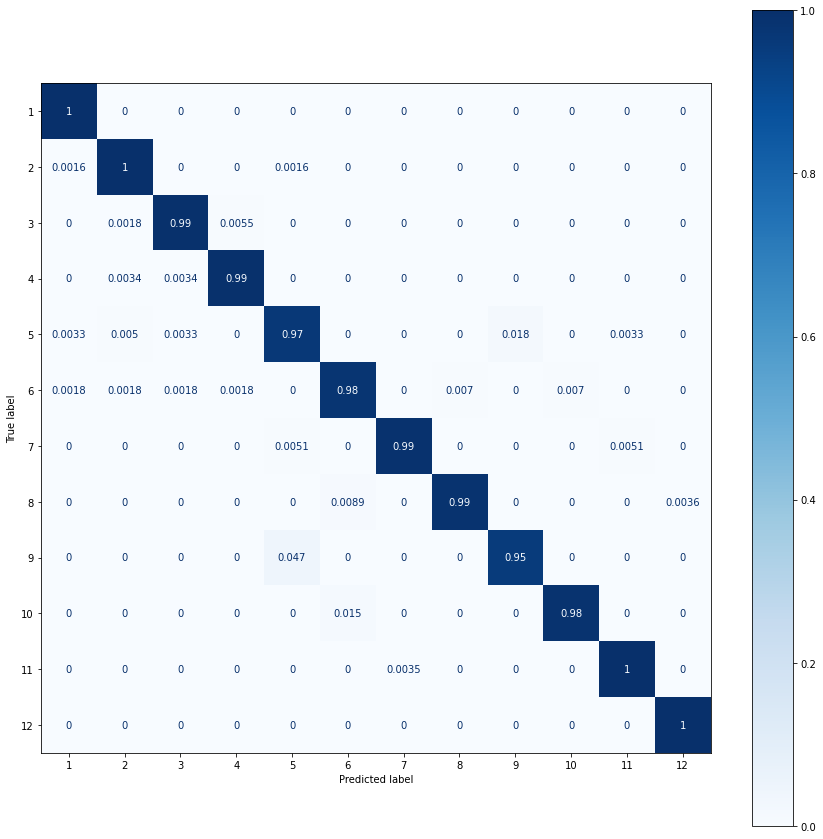

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, test_data_original, test_y, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      4083
           2       0.88      0.96      0.92       590
           3       0.94      0.98      0.96       430
           4       0.94      0.25      0.40        64
           5       0.92      0.97      0.95      1555
           6       0.89      0.97      0.93      1563
           7       0.99      0.71      0.83       157
           8       0.95      0.58      0.72       208
           9       1.00      0.53      0.69       163
          10       1.00      0.46      0.63       151
          11       0.00      0.00      0.00        19
          12       1.00      0.06      0.11        17

    accuracy                           0.94      9000
   macro avg       0.88      0.62      0.68      9000
weighted avg       0.94      0.94      0.94      9000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


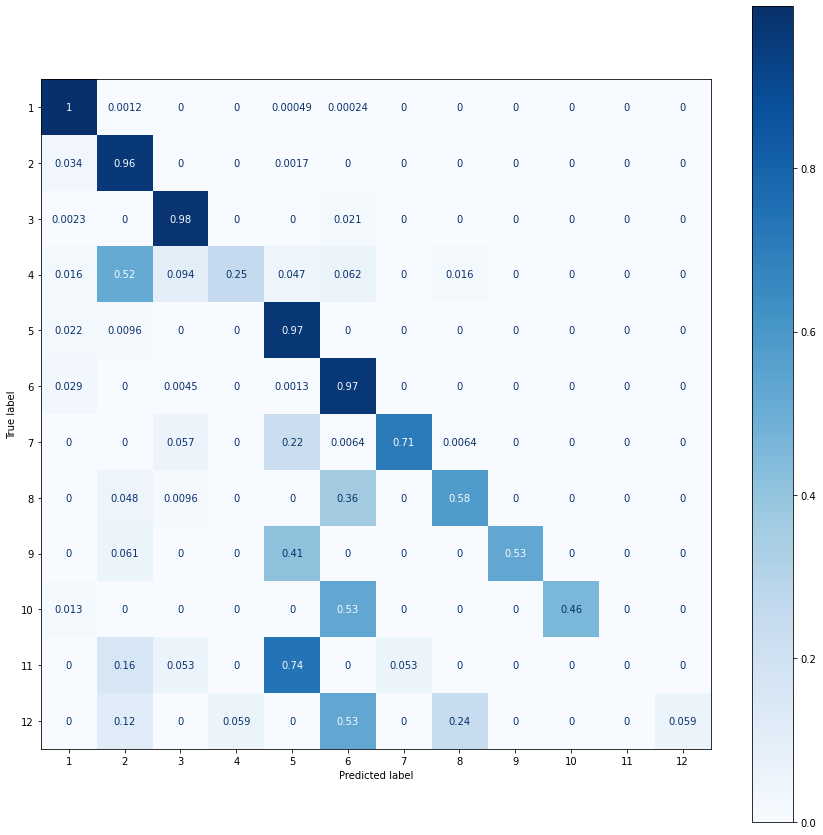

In [ ]:
# from sklearn.metrics import plot_confusion_matrix
# fig, ax = plt.subplots(figsize=(15, 15))
# plot_confusion_matrix(clf, test_data_reduced, test_y, normalize='true', cmap=plt.cm.Blues, ax=ax)
# plt.show()

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(test_y, clf.predict(test_data_original))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4194
           2       0.96      0.99      0.98       595
           3       0.97      0.99      0.98       382
           4       1.00      0.57      0.72        51
           5       0.93      1.00      0.96      1540
           6       0.94      1.00      0.97      1519
           7       0.98      0.94      0.96       177
           8       0.98      0.95      0.96       208
           9       1.00      0.38      0.56       164
          10       1.00      0.45      0.62       137
          11       1.00      0.06      0.11        18
          12       1.00      0.13      0.24        15

    accuracy                           0.97      9000
   macro avg       0.98      0.70      0.75      9000
weighted avg       0.97      0.97      0.96      9000



In [ ]:
from sklearn.metrics import classification_report #R/noR model
print(classification_report(new_test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7194
           1       0.99      0.92      0.95      1806

    accuracy                           0.98      9000
   macro avg       0.99      0.96      0.97      9000
weighted avg       0.98      0.98      0.98      9000



In [ ]:
from sklearn.metrics import classification_report #R/noR model - with balanced data
print(classification_report(new_test_y, clf.predict(test_data_reduced))) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1706
           1       0.97      1.00      0.99      5148

    accuracy                           0.98      6854
   macro avg       0.98      0.96      0.97      6854
weighted avg       0.98      0.98      0.98      6854



Trying NN model

In [ ]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()

        self.fc1 = nn.Linear(1936, 1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,12)

    def forward(self, x):
      return F.relu(self.fc4(F.relu(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x))))))))

In [ ]:
nn_model = NNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(nn_model.parameters(), lr = 0.1)
EPOCHS = 1000
BATCH_SIZE = 4
nn_model.train()

NNModel(
  (fc1): Linear(in_features=1936, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
y = [label - 1 for label in y]
test_y = [label -1 for label in test_y]

In [ ]:
import torch.utils.data as data_utils
train = data_utils.TensorDataset(torch.FloatTensor(data_reduced),torch.tensor(y))

In [ ]:
train_dataLoader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE)

In [ ]:
for epoch in range(20):
  training_loss=0.0
  nn_model.train()
  for x,y in train_dataLoader:

    # print(x.shape)
    # print(y)

    optimizer.zero_grad()
    loss = criterion(nn_model(x),y)
    training_loss+= loss.detach().numpy()
    loss.backward()
    optimizer.step()
  
  if(epoch%5==1):
    nn_model.eval()
    output_logits = nn_model(torch.FloatTensor(test_data_reduced))
    output_labels = np.argmax(output_logits.detach().numpy(),axis=1)
    print(classification_report(test_y, output_labels)) #30000 samples and 9000 val set


In [ ]:
nn_model.eval()

NNModel(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=12, bias=True)
)

In [ ]:
output_logits = nn_model(torch.FloatTensor(test_data_reduced))
output_labels = np.argmax(output_logits.detach().numpy(),axis=1)

In [ ]:
print(classification_report(test_y, output_labels)) #30000 samples and 9000 val set

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4092
           1       0.88      0.69      0.77       614
           2       0.81      0.83      0.82       376
           3       0.65      0.28      0.40        60
           4       0.85      0.95      0.90      1554
           5       0.84      0.97      0.90      1569
           6       0.84      0.31      0.45       167
           7       0.37      0.43      0.40       189
           8       0.40      0.01      0.02       176
           9       0.17      0.01      0.01       168
          10       0.00      0.00      0.00        16
          11       0.00      0.00      0.00        19

    accuracy                           0.88      9000
   macro avg       0.56      0.46      0.47      9000
weighted avg       0.86      0.88      0.86      9000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
